# Segmentación de Clientes para DesignReels

En el competitivo mundo del comercio electrónico, entender a fondo a nuestros clientes es fundamental para ofrecer experiencias personalizadas y maximizar la satisfacción y lealtad del cliente. Este análisis de segmentación de clientes tiene como objetivo explorar y comprender las distintas características y comportamientos de los clientes que interactúan con nuestra tienda en línea, especializada en productos creativos.

Utilizando técnicas avanzadas de análisis de datos, como clustering y segmentación, este estudio buscará identificar grupos homogéneos de clientes. Estos segmentos nos permitirán personalizar estrategias de marketing más efectivas, optimizar la selección de productos y mejorar la experiencia general de compra. Al comprender las necesidades y preferencias únicas de cada segmento, aspiramos a fortalecer la conexión emocional con la marca y aumentar la retención de clientes a largo plazo.

A lo largo de este análisis, exploraremos cómo diferentes segmentos de clientes interactúan con nuestros productos, qué atributos compartidos tienen y cómo podemos adaptar nuestras iniciativas de negocio para satisfacer mejor sus expectativas. Este enfoque estratégico no solo impulsará el crecimiento y la rentabilidad de DesignReels, sino que también nos permitirá destacar en un mercado saturado al ofrecer soluciones que verdaderamente resuenen con nuestros clientes.

Juntos, avanzaremos hacia una comprensión más profunda de nuestros clientes y hacia la creación de experiencias de compra personalizadas y significativas que fortalezcan la posición de DesignReels como líder en su categoría de productos creativos.


# Diccionario de datos 

El conjunto de datos contiene información detallada sobre las transacciones de ventas de la tienda 

Descripción de las Columnas

- invoice_no: Número de factura generado para cada transacción.
- stock_code: Código único que identifica cada producto vendido.
- description: Descripción del producto vendido.
- quantity: Cantidad de unidades vendidas de cada producto en la factura.
- invoice_date: Fecha y hora en que se emitió la factura.
- unit_price: Precio unitario del producto en la factura.
- customer_id: Identificación única del cliente que realizó la compra.
- region: Región o ubicación del cliente.
- total: Total de la venta, calculado como la cantidad vendida multiplicada por el precio unitario.

In [221]:
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score

In [222]:
df = pd.read_csv(r'datasets\Online_Retail.csv', encoding='iso-8859-1')

In [223]:
df.sample(10)

INVOICE_NO STOCK_CODE                         DESCRIPTION  QUANTITY  \
210952     555327     85099B             JUMBO BAG RED RETROSPOT         2   
437896     574298      21944              KITTENS DESIGN FLANNEL         1   
121246     546751      82583                HOT BATHS METAL SIGN         3   
96653      544573       POST                             POSTAGE         5   
46796      540362      21672  WHITE SPOT RED CERAMIC DRAWER KNOB         1   
538505     581406     46000S        POLYESTER FILLER PAD 40x40cm       300   
336856     566408      22554    PLASTERS IN TIN WOODLAND ANIMALS         3   
504321     578947      22189             CREAM HEART CARD HOLDER         1   
193071     553505      23170            REGENCY TEA PLATE ROSES         12   
416951     572567      21669     BLUE STRIPE CERAMIC DRAWER KNOB        24   

            INVOICE_DATE  UNIT_PRICE  CUSTOMER_ID          REGION  
210952  02/06/2020 11:03        4.13          NaN  United Kingdom  
437896  03/11/2020 15:56        1.63          NaN  United Kingdom  
121246  16/03/2020 12:45        2.10      13668.0  United Kingdom  
96653   21/02/2020 13:40       18.00      12621.0         Germany  
46796   06/01/2020 15:42        1.25      13656.0  United Kingdom  
538505  08/12/2020 13:58        0.00          NaN  United Kingdom  
336856  12/09/2020 13:43        1.65      16984.0  United Kingdom  
504321  27/11/2020 13:49        3.95      14547.0  United Kingdom  
193071  17/05/2020 13:27        1.65      12949.0  United Kingdom  
416951  25/10/2020 10:27        1.45      12398.0     Switzerland

In [224]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   INVOICE_NO    541909 non-null  object 
 1   STOCK_CODE    541909 non-null  object 
 2   DESCRIPTION   540455 non-null  object 
 3   QUANTITY      541909 non-null  int64  
 4   INVOICE_DATE  541909 non-null  object 
 5   UNIT_PRICE    541909 non-null  float64
 6   CUSTOMER_ID   406829 non-null  float64
 7   REGION        541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# Analis y limpieza de datos

In [225]:
# Transformar los nombres de las columnas a minúsculas, eliminar los espacios 
# iniciales y finales y reemplazar los espacios con guiones bajos.

new_col_name = []

for old_name in df.columns:
    
    name_stripped = old_name.strip()
    name_lowered = name_stripped.lower()
    name_no_spaces = name_lowered.replace(' ', '_')
    new_col_name.append(name_no_spaces)

df.columns = new_col_name


In [226]:
#cambio de tipo de la columna invoce_date a datetime
df['invoice_date']=pd.to_datetime(df['invoice_date'], format="%d/%m/%Y %H:%M")

#se llenan los nan de la columna customer_id con 0
df['customer_id'] = df['customer_id'].fillna(0)

#cambio del tipo de la columna customer_id a entero
df['customer_id'] = df['customer_id'].astype(int)

#se convierten las descripciones a minuscula para unificar el formato 
df['description'] = df['description'].str.lower()

In [227]:
df['region'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [228]:
#se remplaza el nombre de los paises agregaqdos como EIRE y RSA para unificar todos los nombres en ingles y mayusculas y minusculas 
df['region']= df['region'].replace('EIRE', 'Ireland')

df['region']= df['region'].replace('RSA', 'Sudafrica')

In [229]:
#verificacion de los valores menores a cero en la columan quantity. Se toma la decision de eliminarlo al no considerar que aporten informacion relevante 
df[df['quantity'] < 0]

invoice_no stock_code                       description  quantity  \
141       C536379          D                          discount        -1   
154       C536383     35004C   set of 3 coloured  flying ducks        -1   
235       C536391      22556    plasters in tin circus parade        -12   
236       C536391      21984  pack of 12 pink paisley tissues        -24   
237       C536391      21983  pack of 12 blue paisley tissues        -24   
...           ...        ...                               ...       ...   
540449    C581490      23144   zinc t-light holder stars small       -11   
541541    C581499          M                            manual        -1   
541715    C581568      21258        victorian sewing box large        -5   
541716    C581569      84978  hanging heart jar t-light holder        -1   
541717    C581569      20979     36 pencils tube red retrospot        -5   

              invoice_date  unit_price  customer_id          region  
141    2019-12-01 09:41:00       27.50        14527  United Kingdom  
154    2019-12-01 09:49:00        4.65        15311  United Kingdom  
235    2019-12-01 10:24:00        1.65        17548  United Kingdom  
236    2019-12-01 10:24:00        0.29        17548  United Kingdom  
237    2019-12-01 10:24:00        0.29        17548  United Kingdom  
...                    ...         ...          ...             ...  
540449 2020-12-09 09:57:00        0.83        14397  United Kingdom  
541541 2020-12-09 10:28:00      224.69        15498  United Kingdom  
541715 2020-12-09 11:57:00       10.95        15311  United Kingdom  
541716 2020-12-09 11:58:00        1.25        17315  United Kingdom  
541717 2020-12-09 11:58:00        1.25        17315  United Kingdom  

[10624 rows x 8 columns]

In [230]:
#verificacion de los valores menores a cero en la columan unit_price. Se toma la decision de eliminarlo al no considerar que aporten informacion relevante  
df[df['unit_price'] < 0]

invoice_no stock_code      description  quantity        invoice_date  \
299983    A563186          B  adjust bad debt         1 2020-08-12 14:51:00   
299984    A563187          B  adjust bad debt         1 2020-08-12 14:52:00   

        unit_price  customer_id          region  
299983   -11062.06            0  United Kingdom  
299984   -11062.06            0  United Kingdom

In [231]:
#verificar que no existe ningun valor 0 en la columna quantity; sin embargo tener en cuenta que si existen aun menores a 0 
df[df['quantity'] == 0]

Empty DataFrame
Columns: [invoice_no, stock_code, description, quantity, invoice_date, unit_price, customer_id, region]
Index: []

In [232]:
#creacion de una nueva columana que calcula el total vendido por factura 
df['total'] = df['quantity'] * df['unit_price']

In [233]:
#se decide eliminar del dataframe los datos que en unit_price y en customer_id sean iguales a 0, dado que consideramos no aportan ningun informacion util para futuros analisis
ceros = df.query('unit_price < 0 & customer_id < 0')

In [234]:
#verificacion relacionado con los datos eliminados 
ceros['description'].unique()

array([], dtype=object)

In [235]:
#verificacion relacionado con los datos eliminados 
ceros['region'].unique()

array([], dtype=object)

In [236]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.year.unique()

array([], dtype=int32)

In [237]:
#verificacion relacionado con los datos eliminados 
ceros['invoice_date'].dt.month.unique()

array([], dtype=int32)

In [238]:
#se filta el data frame despues de las verificaciones anteriores para conservar unicamente los datos que sean diferentes a 0 

df = df.query('unit_price > 0.0 & customer_id > 0 & quantity > 0')

In [239]:
#Se observan los valores maximos de la columna unit price y nos damos cuenta que hay facturas que no son productos como tal, cuyos monton son muy altos dado que el valor por unidad es elevado tambien
#al parecer estas facturas corresponden a gastos de envio y/0 gastos varios que podrian afectar nuestra analisis de clientes, dado que nos interesa unicamente sus compras se eliminan del dataset
df[df['unit_price']>= 450]

invoice_no stock_code                     description  quantity  \
117054     546328          M                          manual         1   
117055     546329          M                          manual         1   
144826     548813          M                          manual         1   
144828     548813          M                          manual         1   
144829     548820          M                          manual         1   
145831     548913          M                          manual         1   
150615     549468          M                          manual         1   
173382     551697       POST                         postage         1   
187584     552980       POST                         postage         1   
188277     553018          M                          manual         1   
200745     554155          M                          manual         1   
201553     554301          M                          manual         1   
201556     554305          M                          manual         1   
222680     556444      22502  picnic basket wicker 60 pieces        60   
222682     556446      22502  picnic basket wicker 60 pieces         1   
236402     557754       POST                         postage         1   
242907     558381          M                          manual         1   
264976     560187       POST                         postage         1   
268399     560413          M                          manual         1   
271252     560651          M                          manual         1   
297438     562946          M                          manual         1   
323876     565377          M                          manual         1   
343000     566927          M                          manual         1   
350599     567656        DOT                  dotcom postage         1   
361584     568346        DOT                  dotcom postage         1   
372766     569246        DOT                  dotcom postage         1   
374542     569382          M                          manual         1   
389983     570488        DOT                  dotcom postage         1   
398150     571223          M                          manual         1   
401766     571441        DOT                  dotcom postage         1   
406406     571751          M                          manual         1   
406407     571751          M                          manual         1   
414251     572423          M                          manual         1   
416463     572552        DOT                  dotcom postage         1   
422351     573077          M                          manual         1   
422376     573080          M                          manual         1   
429588     573576        DOT                  dotcom postage         1   
455261     575607        DOT                  dotcom postage         1   
455621     575632          M                          manual         1   
467436     576339        DOT                  dotcom postage         1   
468046     576389          M                          manual         1   
494728     578270        DOT                  dotcom postage         1   
508459     579196        DOT                  dotcom postage         1   
528082     580727        DOT                  dotcom postage         1   

              invoice_date  unit_price  customer_id          region     total  
117054 2020-03-11 10:19:00     1687.17        14911         Ireland   1687.17  
117055 2020-03-11 10:22:00     1687.17        14911         Ireland   1687.17  
144826 2020-04-04 13:03:00     2382.92        12744       Singapore   2382.92  
144828 2020-04-04 13:03:00     1252.95        12744       Singapore   1252.95  
144829 2020-04-04 13:04:00     2053.07        12744       Singapore   2053.07  
145831 2020-04-05 09:45:00     1136.30        12669          France   1136.30  
150615 2020-04-08 14:27:00     1867.86        17940  United Kingdom   1867.86  
173382 2020-05-03 13:46:00     8142.

In [240]:
#Se eliminando estos valores dado que no parecen ser ventas realizadas como tal por la empresa. 
df = df[~df['stock_code'].isin(['M', 'DOT', 'POST'])]

In [241]:
df[df['unit_price']>= 450]

invoice_no stock_code                     description  quantity  \
222680     556444      22502  picnic basket wicker 60 pieces        60   
222682     556446      22502  picnic basket wicker 60 pieces         1   

              invoice_date  unit_price  customer_id          region    total  
222680 2020-06-10 15:28:00       649.5        15098  United Kingdom  38970.0  
222682 2020-06-10 15:33:00       649.5        15098  United Kingdom    649.5

# Analisis exploratorio de datos

In [242]:
# Agrupar datos por ID de cliente
grouped_df = df.groupby('customer_id')

# Calcula la primera y última fecha de compra de cada cliente
first_purchase_date = grouped_df['invoice_date'].min()
last_purchase_date = grouped_df['invoice_date'].max()

# Calcular la diferencia horaria entre la primera y la última compra (en días)

time_delta = last_purchase_date - first_purchase_date
time_in_days = time_delta.dt.days


# Combinar los resultados en el DataFrame
customer_purchase_time = pd.DataFrame({'time_in_days': time_in_days}).reset_index()

# Mostrar el tiempo de compra del cliente
customer_purchase_time['time_in_days']= customer_purchase_time['time_in_days'].replace(0, 1)
customer_purchase_time

customer_id  time_in_days
0           12346             1
1           12347           366
2           12348           283
3           12349             1
4           12350             1
...           ...           ...
4330        18280             1
4331        18281             1
4332        18282           118
4333        18283           334
4334        18287           158

[4335 rows x 2 columns]

In [243]:
#Creamos un Histograma para visualizar la distribucios del tiempo de vida del cliente en nuestra tienda
import plotly.graph_objects as go
fig = px.histogram(customer_purchase_time, x="time_in_days", nbins=10, text_auto=True, title= 'Distribución del Tiempo de Vida del Cliente en nuestra tienda')
fig.update_layout(
    xaxis_title='Días',
    yaxis_title='Cantidad de Clientes',
    title={
        'text': 'Distribución del Tiempo de Vida del Cliente en nuestra tienda',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'black', 'family': 'Arial Black'}
    },
    xaxis=dict(
        title_font=dict(size=18, family='Arial Black')
    ),
    yaxis=dict(
        title_font=dict(size=18, family='Arial Black')
    ),
    autosize=False,
    width=1000,  # Ancho del gráfico
    height=600   # Alto del gráfico
)

fig.show()

El la visualizacion nos damos cuenta que hay una gran cantidad de nuestros clientes entre el rango de los 0 a los 50 dias, por lo que pueden ser clientes recientes comprando en nuestra tiendo lo cual es bueno, o tambien pueden ser clientes que ya dejaron de comprar y debemoos buscar la forma de retomarlos.

In [244]:
def add_date_components(group):
  """
  Extracts day, month, and year from the 'invoice_date' column within a group.

  Args:
    group: A Pandas group object (subset of the DataFrame).

  Returns:
    The group with added columns 'days', 'months', and 'years'.
  """
  group['days'] = group['invoice_date'].dt.day
  group['months'] = group['invoice_date'].dt.month
  group['years'] = group['invoice_date'].dt.year
  return group

df_with_components = df.groupby('invoice_date').apply(add_date_components)

C:\Users\karin\AppData\Local\Temp\ipykernel_44380\4097401398.py:16: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [245]:
df_with_components.head()

invoice_no stock_code  \
invoice_date                                  
2019-12-01 08:26:00 0     536365     85123A   
                    1     536365      71053   
                    2     536365     84406B   
                    3     536365     84029G   
                    4     536365     84029E   

                                               description  quantity  \
invoice_date                                                           
2019-12-01 08:26:00 0   white hanging heart t-light holder         6   
                    1                  white metal lantern         6   
                    2       cream cupid hearts coat hanger         8   
                    3  knitted union flag hot water bottle         6   
                    4       red woolly hottie white heart.         6   

                             invoice_date  unit_price  customer_id  \
invoice_date                                                         
2019-12-01 08:26:00 0 2019-12-01 08:26:00        2.55        17850   
                    1 2019-12-01 08:26:00        3.39        17850   
                    2 2019-12-01 08:26:00        2.75        17850   
                    3 2019-12-01 08:26:00        3.39        17850   
                    4 2019-12-01 08:26:00        3.39        17850   

                               region  total  days  months  years  
invoice_date                                                       
2019-12-01 08:26:00 0  United Kingdom  15.30     1      12   2019  
                    1  United Kingdom  20.34     1      12   2019  
                    2  United Kingdom  22.00     1      12   2019  
                    3  United Kingdom  20.34     1      12   2019  
                    4  United Kingdom  20.34     1      12   2019

In [246]:
#Filtramos los datos para encontrar el top 10 de las regiones con mayores ventas
filtered= df_with_components.groupby('region')['total'].sum().reset_index().sort_values(by='total', ascending=False).head(10)
top_10_region= df_with_components['region'].tolist()
filtered_df = df_with_components[df_with_components['region'].isin(top_10_region)]
filtered_df_new= filtered_df.groupby(['region', 'days', 'months', 'years'])['total'].sum().reset_index().sort_values(by='total', ascending=False)
filtered_df_new


region  days  months  years      total
1285  United Kingdom     9      12   2020  179562.78
1395  United Kingdom    20       9   2020  100457.88
1369  United Kingdom    18       1   2020   84035.94
1345  United Kingdom    15       9   2020   65843.34
1283  United Kingdom     9      11   2020   58843.67
...              ...   ...     ...    ...        ...
532          Germany    13      12   2019      12.45
907      Netherlands    20       7   2020      11.02
1115          Sweden    11       5   2020       8.50
1162     Switzerland    21       9   2020       4.95
351           France    16      12   2019       4.95

[1500 rows x 5 columns]

In [247]:
#Creamos una visualizacion para ver la distribucion de ventas.
fig = px.scatter(filtered_df_new, x="months", y="total", color="region",
                 size='days', hover_data=['years'],
                 title='Distribucion de Ventas por dia/mes/año y region')

fig.update_layout(
    title={
        'text': 'Distribución de Ventas por día/mes/año y región', 
        'x': 0.5, 
        'xanchor': 'center', 
        'yanchor': 'top', 
        'font': {'size': 24, 'family': 'Arial', 'color': 'black'}
    },
    xaxis_title={
        'text': 'Meses', 
        'font': {'size': 20, 'family': 'Arial', 'color': 'black'}
    },
    yaxis_title={
        'text': 'Ingresos por ventas', 
        'font': {'size': 20, 'family': 'Arial', 'color': 'black'}
    },
    width=1200,
    height=800
)

fig.show()

In [248]:
#Filtramos los datos para calcular los el tiempo de vida de un cliente comprando en nuestra tienda.
customer_days= df_with_components.groupby(['customer_id', 'months', 'years'])
max_days= customer_days['invoice_date'].max()
min_days= customer_days['invoice_date'].min()
total= max_days - min_days
total= total.dt.days.reset_index()
total['invoice_date']= total['invoice_date'].replace(0, 1)
total.sort_values(by='invoice_date')

customer_id  months  years  invoice_date
0           12346       1   2020             1
7759        15835      10   2020             1
7760        15836      10   2020             1
7761        15837      10   2020             1
7762        15838       2   2020             1
...           ...     ...    ...           ...
9927        16839       7   2020            29
901         12709       3   2020            29
5824        14911       7   2020            30
4074        14156       7   2020            30
1023        12748       7   2020            30

[13029 rows x 4 columns]

In [249]:
#Agregamos una nueva colunma incorparando en ella valores 1 para casos de estudios a futuro de las faturaciones.
total['buy_month'] = 1
total

customer_id  months  years  invoice_date  buy_month
0            12346       1   2020             1          1
1            12347       1   2020             1          1
2            12347       4   2020             1          1
3            12347       6   2020             1          1
4            12347       8   2020             1          1
...            ...     ...    ...           ...        ...
13024        18283      10   2020             1          1
13025        18283      11   2020            19          1
13026        18283      12   2020             1          1
13027        18287       5   2020             1          1
13028        18287      10   2020            15          1

[13029 rows x 5 columns]

In [250]:
# Filtramos los datos por años para luego generar el histograma
group_1= total[total['years']== 2019]
group_2= total[total['years']== 2020]

fig = go.Figure()
fig.add_trace(go.Histogram(x=group_1['months'], name= '2019', texttemplate="%{y}", marker_line_color='black', marker_line_width=1))
fig.add_trace(go.Histogram(x=group_2['months'], name= '2020', texttemplate="%{y}", marker_line_color='black', marker_line_width=1))
fig.update_layout(
    title_text='Cantidad de compras mensuales/año', # título del gráfico
    xaxis_title_text='Meses', # título del eje x
    yaxis_title_text='Cantidad de Clientes', # título del eje y
    title={
        'font': {'size': 24, 'family': 'Arial', 'color': 'black'}
    },
    xaxis={
        'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black'}}
    },
    yaxis={
        'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black'}}
    },
    width=1200,
    height=800,
    barmode='overlay'
)

fig.update_traces(opacity=0.75)
fig.show()

Podemos observar en el grafico que tenemos registro del año 2019 solo del mes 12.

Tambien es importante observar que el numero de facturaciones mensuales durante los meses 9, 10 y 11 aumentan significativamente, dando a entender que son los mejores meses de ventas.

El mes de diciembre habria que se puede mejorar ya que baja significativamente la cantidad de ventas en dicho mes

In [251]:
# Agrupamos por Nº de factura y calcular el valor medio por transacción
average_value_per_transaction = df.groupby('invoice_no')['total'].mean().reset_index()

# Cambie el nombre de las columnas para mayor claridad
average_value_per_transaction.columns = ['invoice_no', 'average_value']

# Mostrar las primeras filas del resultado
average_value_per_transaction

invoice_no  average_value
0         536365      19.874286
1         536366      11.100000
2         536367      23.227500
3         536368      17.512500
4         536369      17.850000
...          ...            ...
18411     581583      62.300000
18412     581584      70.320000
18413     581585      15.669048
18414     581586      84.800000
18415     581587      16.630000

[18416 rows x 2 columns]

In [252]:
# Calcular el tiempo entre cada transacción para cada cliente
df['time_diff']= df.groupby('customer_id')['invoice_date'].diff().dt.days

# Calcular la media del tiempo entre transacciones para cada cliente
avg_time_between_purchases = df.groupby('customer_id')['time_diff'].mean().reset_index()
avg_time_between_purchases.columns = ['customer_id', 'avg_days_between_purchases']

# Graficar los resultados de manera interactiva con Plotly Express
fig = px.histogram(avg_time_between_purchases, x='avg_days_between_purchases', nbins=20, title='Distribución del tiempo promedio entre compras')
fig.update_layout(
    xaxis_title='Días promedio entre compras', 
    yaxis_title='Número de Clientes',
    title={
        'text': 'Distribución del tiempo promedio entre compras',
        'font': {'size': 24, 'family': 'Arial', 'color': 'black'}
    },
    xaxis={
        'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black'}}
    },
    yaxis={
        'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black'}}
    },
    width=1200,
    height=800
)
fig.show()

Podemos observar en la grafica que la gran mayoria de los clientes vuelven a comprar en un lapso no mayor a 10 dias.

In [253]:
# Definimos umbrales para segmentar a los clientes
threshold_frequent = 10  # Por ejemplo, clientes que compran cada 15 días o menos
threshold_occasional = 70 # Por ejemplo, clientes que compran entre 15 y 30 días

# Creamos una nueva columna para la segmentación
avg_time_between_purchases['segment'] = 'Ocasional'
avg_time_between_purchases.loc[avg_time_between_purchases['avg_days_between_purchases'] <= threshold_frequent, 'segment'] = 'Frecuente'
avg_time_between_purchases.loc[(avg_time_between_purchases['avg_days_between_purchases'] > threshold_frequent) & (avg_time_between_purchases['avg_days_between_purchases'] <= threshold_occasional), 'segment'] = 'Medio'

# Analizamos las características de cada grupo
print(avg_time_between_purchases.groupby('segment')['avg_days_between_purchases'].describe())

            count        mean        std        min        25%         50%  \
segment                                                                      
Frecuente  4008.0    1.677613   2.146939   0.000000   0.000000    0.918110   
Medio       237.0   20.512257  12.054443  10.111111  12.352941   16.136364   
Ocasional    17.0  130.975490  62.840322  74.000000  97.000000  115.000000   

                  75%         max  
segment                            
Frecuente    2.496681   10.000000  
Medio       23.333333   69.666667  
Ocasional  127.500000  310.000000  


1. Mayoria de clientes frecuentes:

El hecho de que la mayoria de nuestros clientes (4008) pertenezcan al segmento 'Frecuente' con un promedio de 1.67 dias entre compras, indica que tenemos una base solida de clientes leales que compran con regularidad

2. Oportunidad de crecimiento en el segmento 'Medio':

El segmento 'Medio' (237 clientes) presenta un promedio de 20.5 dias entre compras. Esto sugiere que existe una oportunidad de convertir a estos clientes en compradores mas frecuentes. podriamos explorar estrategias de marketing personalizadas, como descuentas exclusivos, programas de fidelizacion o recomendaciones de productos basados en sus compras.

3. Atencion al segmento 'Ocasional':

El segmento 'Ocasional' (17 clientes) muestra un promedio de 130 dias entre compras y una alta desviacion estandar. Podriamos investigar las razones detras de esta baja frecuencia para reactivarlos, como enviarles recordatorios, ofertas especiales ocontenido relevante a sus intereses.

Recomendaciones:

- Fortalecer la relación con los clientes frecuentes:


Continúa brindando un excelente servicio al cliente, ofreciendo productos de calidad y desarrollando programas de fidelización para mantener a estos clientes satisfechos y leales.


- Incentivar la compra frecuente en el segmento "Medio":


Implementa estrategias de marketing personalizadas para motivar a estos clientes a comprar con mayor frecuencia, como descuentos por volumen, envío gratuito o acceso anticipado a nuevos productos.


- Reactivar a los clientes "Ocasionales":


Identifica las razones detrás de su baja frecuencia de compra y desarrolla estrategias para reengancharlos, como campañas de email marketing, ofertas personalizadas o contenido relevante a sus intereses.


- Analizar más a fondo los datos:


Investiga otros factores que pueden influir en la frecuencia de compra, como el tipo de producto, el canal de venta, la ubicación geográfica, etc. Esto te permitirá personalizar aún más tus estrategias de marketing y mejorar la retención de clientes.

In [254]:
# Agrupamos los datos por factura y totales para sacar la media de compras
invoice_totals = df.groupby('invoice_no')['total'].sum().reset_index()
average_purchase_value = invoice_totals['total'].mean()


print(invoice_totals)
print()
print('El valor promedio por compra de cada cliente es:', average_purchase_value)

      invoice_no   total
0         536365  139.12
1         536366   22.20
2         536367  278.73
3         536368   70.05
4         536369   17.85
...          ...     ...
18411     581583  124.60
18412     581584  140.64
18413     581585  329.05
18414     581586  339.20
18415     581587  249.45

[18416 rows x 2 columns]

El valor promedio por compra de cada cliente es: 476.1032609687228


In [255]:
# Agrupar por fecha y calcular el valor medio por transacción
average_value_per_day = df_with_components.groupby(df_with_components['invoice_date'])['total'].mean().reset_index()

# Cambie el nombre de las columnas para mayor claridad
average_value_per_day.columns = ['date', 'average_value']

# Mostrar las primeras filas del resultado
print(average_value_per_day.head())

fig = go.Figure()
fig.add_trace(go.Scatter(x=average_value_per_day['date'], y=average_value_per_day['average_value'],
                    mode='lines+markers',
                    name='lines+markers',
                    ))
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Valor Promedio por Compra',
    title={
        'text': 'Evolución del Valor Promedio por Compra a lo Largo del Tiempo',
        'x': 0.5,  # Alineación central del título
        'xanchor': 'center',  # Anclaje horizontal al centro
        'font': {'size': 24, 'family': 'Arial', 'color': 'black', 'weight': 'bold'}  # Fuente en negritas
    },
    xaxis={'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black', 'weight': 'bold'}}},  # Formato del eje x
    yaxis={'title': {'font': {'size': 20, 'family': 'Arial', 'color': 'black', 'weight': 'bold'}}},  # Formato del eje y
    width=1200,  # Ancho de la figura
    height=800  # Alto de la figura
)
fig.show()

                 date  average_value
0 2019-12-01 08:26:00      19.874286
1 2019-12-01 08:28:00      11.100000
2 2019-12-01 08:34:00      21.798750
3 2019-12-01 08:35:00      17.850000
4 2019-12-01 08:45:00      42.203158


Podemos observar en el grafico anterior 2 anomalias de compras, las cuales al verificar la primera es un cliente que ha realizado ya varias compras con nosotros y el otro es un cliente que sus primeras 2 compras fueron pequeñas pero luego el 9 de diciembre de 2020 realiza una compra grande de (80995) paper craft little birdie. el cual da un total de 168469.60

El resto de los datos se mantiene dentro de los rangos normales.

In [256]:
# Agrupe por fecha y calcular el valor medio por transacción
average_value_per_day = df_with_components.groupby(df_with_components['invoice_date'])['total'].mean().reset_index().sort_values(by='total', ascending=False)

# Cambie el nombre de las columnas para mayor claridad
average_value_per_day.columns = ['date', 'average_value']

# Elimine las filas con índices '17149' y '1775' las cuales pertenecena los 2 datos atipicos
average_value_per_day_filtered = average_value_per_day.iloc[2:]

# Mostrar las primeras filas del resultado
print(average_value_per_day_filtered.head())

fig = go.Figure()
fig.add_trace(go.Scatter(x=average_value_per_day_filtered['date'], y=average_value_per_day_filtered['average_value'],
                    mode='lines+markers',
                    name='lines+markers',
                    ))
fig.update_layout(
    xaxis_title='Fecha',
    yaxis_title='Valor Promedio por Compra',
    title='Evolución del Valor Promedio por Compra a lo Largo del Tiempo',
    width=1200,
    height=800
)

fig.show()

                     date  average_value
13796 2020-10-27 12:11:00    4992.000000
7430  2020-06-10 15:28:00    4391.711111
5156  2020-04-18 13:20:00    4307.180000
1572  2020-01-11 12:57:00    3918.750000
16989 2020-12-07 12:20:00    3861.000000




En este caso obviamos los 2 valores que tuvimos en el grafico anterios para en este caso poder ver mas de cerca la Evolucion del promedio de compra, en el cual podemos observar que en su gran mayoria esta por debajo de los 1000, pero tambien podemos notar una cantidad importante de clientes por encima de los 1000.

Se pueden aplicar estrategias como las mencionadas anteriormente para lograr que los clientes que estan por debajo de los 1000 evolucionen sus compras por encima de los 1000 o por lo menos lo mas cerca posible.

      customer_id  average_value
0           12346       77183.60
3007        16446       56157.50
2011        15098       13305.50
2502        15749        4453.43
2087        15195        3861.00


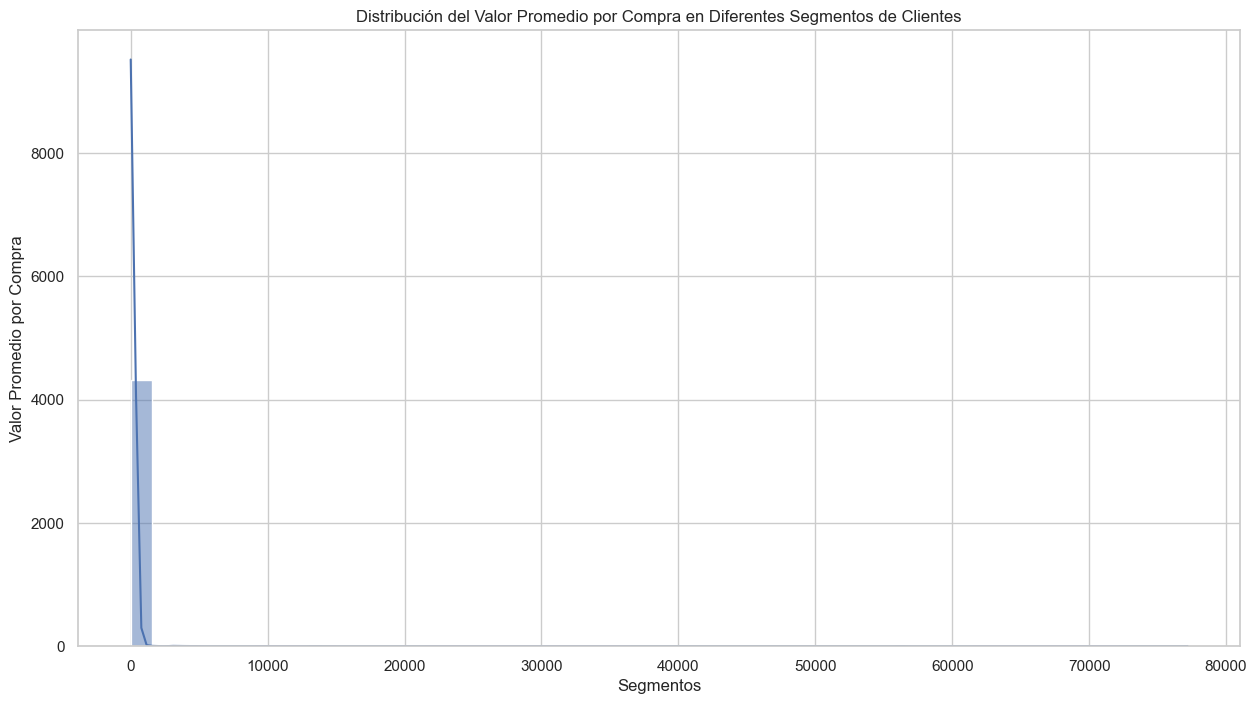

In [257]:
# Agrupe por cliente y calcule el valor medio por transacción
average_value_per_customer = df_with_components.groupby('customer_id')['total'].mean().reset_index().sort_values(by='total', ascending=False)

# Cambie el nombre de las columnas para mayor claridad
average_value_per_customer.columns = ['customer_id', 'average_value']

# Mostramos las primeras filas del resultado
print(average_value_per_customer.head())

# Trazamos la distribución del valor promedio por transacción para diferentes segmentos de clientes
import seaborn as sns
plt.figure(figsize=(15, 8))
sns.histplot(average_value_per_customer['average_value'], bins=50, kde=True)
plt.title('Distribución del Valor Promedio por Compra en Diferentes Segmentos de Clientes')
plt.xlabel('Segmentos')
plt.ylabel('Valor Promedio por Compra')
plt.grid(True)
plt.show()


- Los clientes con un valor promedio por compra de entre 2.000 y 4.000 representan la mayor parte de la base de clientes. Esto sugiere que estas son las categorías de clientes más importantes para la empresa.


- Los clientes con un valor promedio por compra superior a 4.000 representan una pequeña parte de la base de clientes, pero generan una gran cantidad de ingresos. Esto sugiere que estos clientes son muy valiosos para la empresa.

- Los clientes con un valor promedio por compra inferior a 2.000 representan una parte significativa de la base de clientes, pero generan una pequeña cantidad de ingresos. Esto sugiere que estos clientes pueden no ser tan valiosos para la empresa.

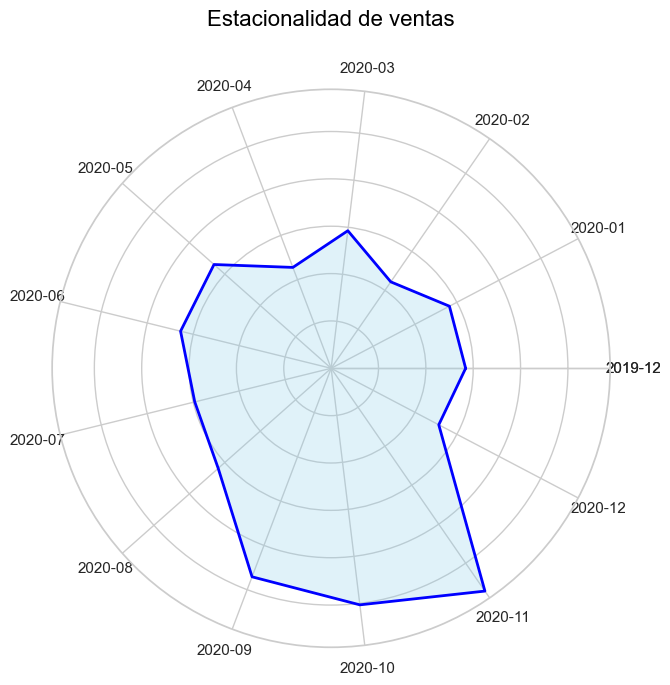

In [258]:
# Estacionalidad de ventas GRAFICO DE RADAR/SPIDER

df['invoice_date'] = pd.to_datetime(df['invoice_date'])

df['month_year'] = df['invoice_date'].dt.to_period('M')

ventas_mensuales = df.groupby('month_year')['total'].sum().reset_index()

ventas_mensuales['month_year'] = ventas_mensuales['month_year'].dt.to_timestamp()

labels = ventas_mensuales['month_year'].dt.strftime('%Y-%m').tolist()
stats = ventas_mensuales['total'].values

num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

stats = np.concatenate((stats, [stats[0]]))
angles += angles[:1]
labels += [labels[0]]

fig, ax = plt.subplots(figsize=(15, 7), subplot_kw=dict(polar=True))

ax.fill(angles, stats, color='skyblue', alpha=0.25)
ax.plot(angles, stats, color='blue', linewidth=2)

ax.set_xticks(angles)
ax.set_xticklabels(labels)

plt.title('Estacionalidad de ventas', size=16, color='black', y=1.1)
ax.set_yticklabels([])

plt.tight_layout()
plt.show()

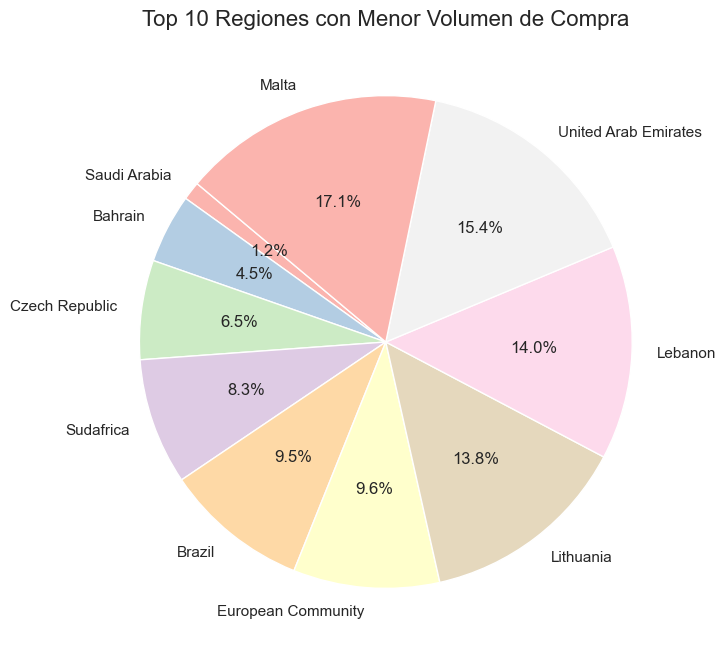

In [259]:
#Bottom 10 regiones con el menor volumen de ventas
ventas_por_region = df.groupby('region')['total'].sum().sort_values()

#Seleccionar las 10 regiones con el menor volumen de compras
bottom_10_regiones = ventas_por_region.head(10)

#Crear el gráfico de torta
plt.figure(figsize=(15, 8))
plt.pie(bottom_10_regiones, labels=bottom_10_regiones.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Top 10 Regiones con Menor Volumen de Compra', fontsize=16)
plt.show()

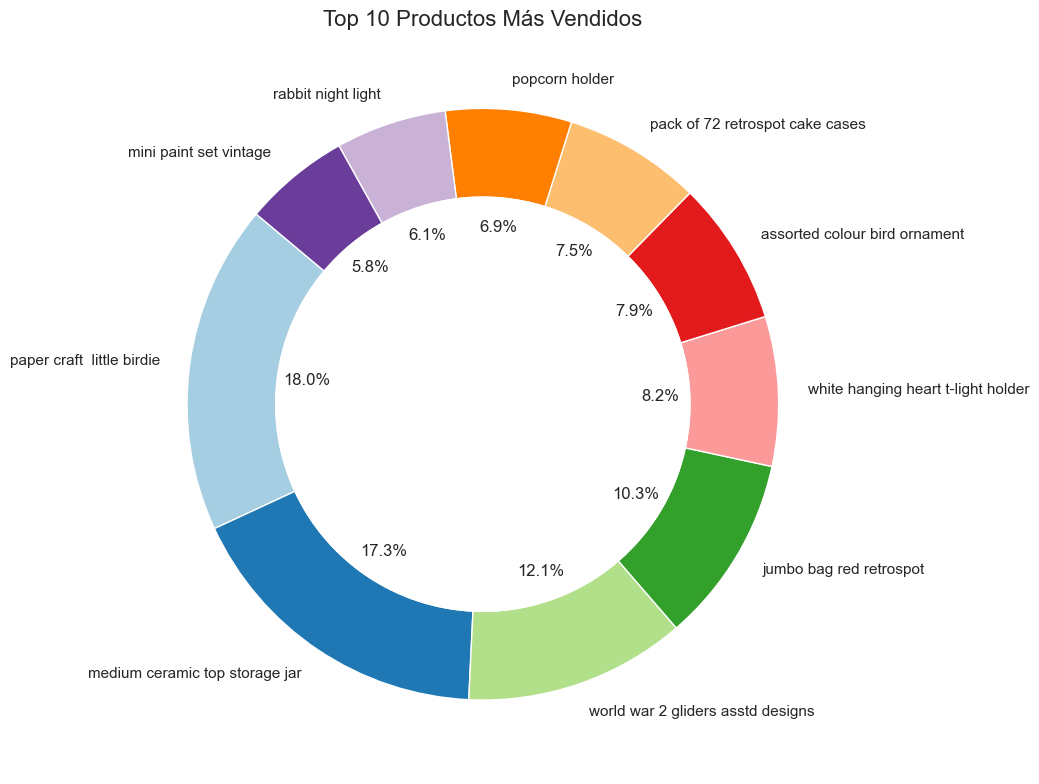

In [260]:
#Productos más vendidos segun descripción GRAFICO DE DONA
productos_mas_vendidos = df.groupby('description')['quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(15, 8))
plt.pie(productos_mas_vendidos, labels=productos_mas_vendidos.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors, wedgeprops=dict(width=0.3))


centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)


plt.title('Top 10 Productos Más Vendidos', fontsize=16)

plt.tight_layout()
plt.show()

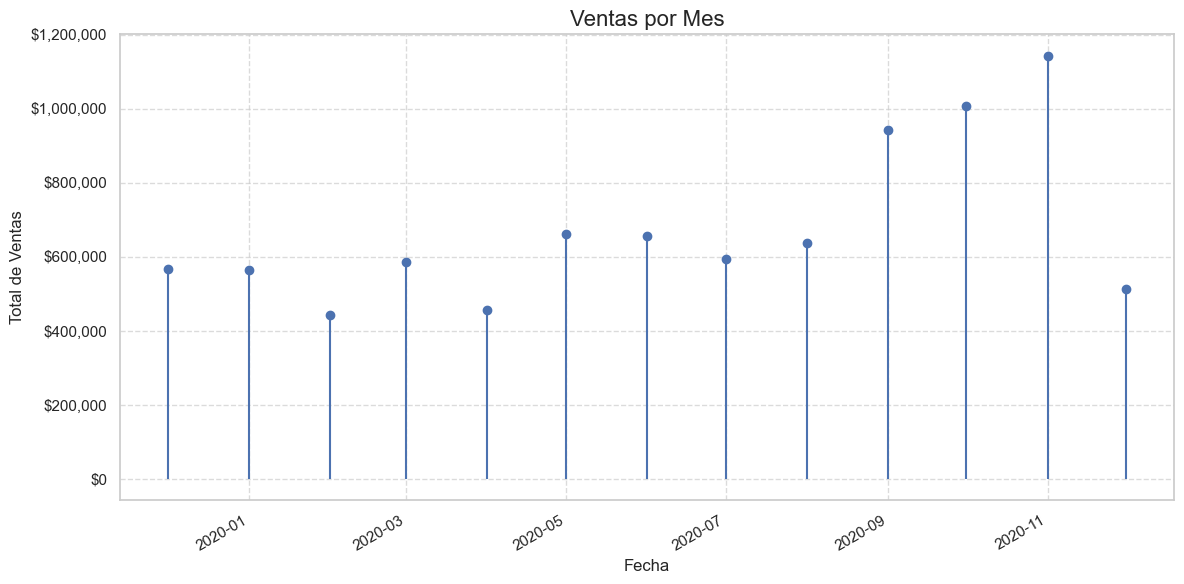

In [261]:
# Convertir invoice_date a formato datetime si no lo está
df['invoice_date'] = pd.to_datetime(df['invoice_date'])

# Agrupar por mes y sumar las ventas totales
ventas_mensuales = df.groupby(df['invoice_date'].dt.to_period('M'))['total'].sum().reset_index()

# Convertir la columna de fechas a formato timestamp
ventas_mensuales['invoice_date'] = ventas_mensuales['invoice_date'].dt.to_timestamp()

# Crear el gráfico de lollipop
plt.figure(figsize=(12, 6))
plt.stem(ventas_mensuales['invoice_date'], ventas_mensuales['total'], linefmt='b-', markerfmt='bo', basefmt=" ")

# Configuración del gráfico
plt.title('Ventas por Mes', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Total de Ventas', fontsize=12)
plt.gcf().autofmt_xdate()  # Formato automático de las fechas en el eje x
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))  # Formato de los números en el eje y
plt.grid(True, linestyle='--', alpha=0.7)  # Activar la cuadrícula con estilo punteado y transparencia
plt.tight_layout()  # Ajuste del diseño del gráfico
plt.show()  # Mostrar el gráfico

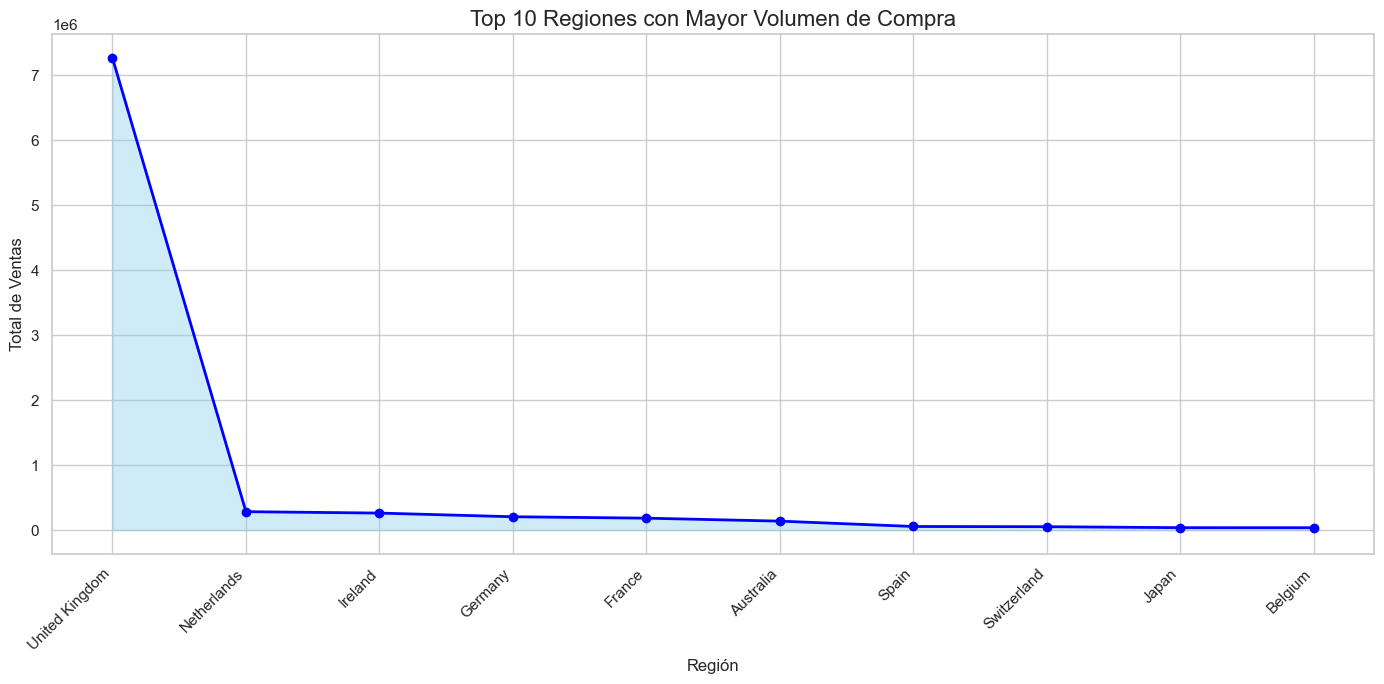

In [262]:
#Top 10 regiones que más compran GRÁFICO DE AREA
ventas_por_region = df.groupby('region')['total'].sum().sort_values(ascending=False)

top_10_regiones = ventas_por_region.head(10)

plt.figure(figsize=(14, 7))
plt.fill_between(top_10_regiones.index, top_10_regiones.values, color='skyblue', alpha=0.4)
plt.plot(top_10_regiones.index, top_10_regiones.values, marker='o', color='blue', linewidth=2)

plt.title('Top 10 Regiones con Mayor Volumen de Compra', fontsize=16)
plt.xlabel('Región', fontsize=12)
plt.ylabel('Total de Ventas', fontsize=12)
plt.grid(True)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
#Esta libreria usé para la grfica de lineas paralelas:
from pandas.plotting import parallel_coordinates

## Conclusion 

Luego de nuestros analisis en los datos logramos notar varias cosas:

 - existe una gran cantidad de nuestros clientes entre el rango de los 0 a los 50 dias, por lo que pueden ser clientes recientes comprando en nuestra tiendo lo cual es bueno, o tambien pueden ser clientes que ya dejaron de comprar y debemoos buscar la forma de retomarlos.

- Pudemos que tenemos registro del año 2019 solo del mes 12.

 Tambien es importante comentar que el numero de facturaciones mensuales durante los meses 9, 10 y 11 aumentan significativamente, dando a entender que son los mejores meses de ventas.

 El mes de diciembre habria que se puede mejorar ya que baja significativamente la cantidad de ventas en dicho mes.

 - Podemos observar en el grafico que tenemos registro del año 2019 solo del mes 12.

Tambien es importante observar que el numero de facturaciones mensuales durante los meses 9, 10 y 11 aumentan significativamente, dando a entender que son los mejores meses de ventas.

- El mes de diciembre habria que se puede mejorar ya que baja significativamente la cantidad de ventas en dicho mes.

- Mayoria de clientes frecuentes:
El hecho de que la mayoria de nuestros clientes (4008) pertenezcan al segmento 'Frecuente' con un promedio de 1.67 dias entre compras, indica que tenemos una base solida de clientes leales que compran con regularidad

- Oportunidad de crecimiento en el segmento 'Medio':
El segmento 'Medio' (237 clientes) presenta un promedio de 20.5 dias entre compras. Esto sugiere que existe una oportunidad de convertir a estos clientes en compradores mas frecuentes. podriamos explorar estrategias de marketing personalizadas, como descuentas exclusivos, programas de fidelizacion o recomendaciones de productos basados en sus compras.

- Atencion al segmento 'Ocasional':
El segmento 'Ocasional' (17 clientes) muestra un promedio de 130 dias entre compras y una alta desviacion estandar. Podriamos investigar las razones detras de esta baja frecuencia para reactivarlos, como enviarles recordatorios, ofertas especiales ocontenido relevante a sus intereses.

# Segmentacion de clientes 

In [263]:

# Calcular el número de compras por cliente
numero_compras = df.groupby('customer_id')['invoice_no'].count().reset_index()
numero_compras.columns = ['customer_id', 'numero_compras']

# Calcular los ingresos totales por cliente
ingresos_totales = df.groupby('customer_id')['total'].sum().reset_index()
ingresos_totales.columns = ['customer_id', 'ingresos_totales']

# Unir los datos calculados con el DataFrame original
df = pd.merge(df, numero_compras, on='customer_id', how='left')
df = pd.merge(df, ingresos_totales, on='customer_id', how='left')

# Calcular el número de clientes únicos
numero_clientes_unicos = df['customer_id'].nunique()

# Calcular los clientes retenidos (clientes con más de una compra)
clientes_retenidos = df[df['numero_compras'] > 1]['customer_id'].nunique()

In [264]:
def categorizar_cliente(num_compras):
    if num_compras > 1:
        return 'retenido'
    else:
        return 'perdido'

In [265]:
df['estado_cliente'] = df['numero_compras'].apply(categorizar_cliente)

In [266]:
df['AVP'] = df['ingresos_totales'] / df['numero_compras']

df['APF'] = df['numero_compras'] / numero_clientes_unicos

CR = 1 - (clientes_retenidos / numero_clientes_unicos)

In [267]:
df['CLTV'] = (df['AVP'] * df['APF']) / CR

In [268]:
df.head()

invoice_no stock_code                          description  quantity  \
0     536365     85123A   white hanging heart t-light holder         6   
1     536365      71053                  white metal lantern         6   
2     536365     84406B       cream cupid hearts coat hanger         8   
3     536365     84029G  knitted union flag hot water bottle         6   
4     536365     84029E       red woolly hottie white heart.         6   

         invoice_date  unit_price  customer_id          region  total  \
0 2019-12-01 08:26:00        2.55        17850  United Kingdom  15.30   
1 2019-12-01 08:26:00        3.39        17850  United Kingdom  20.34   
2 2019-12-01 08:26:00        2.75        17850  United Kingdom  22.00   
3 2019-12-01 08:26:00        3.39        17850  United Kingdom  20.34   
4 2019-12-01 08:26:00        3.39        17850  United Kingdom  20.34   

   time_diff month_year  numero_compras  ingresos_totales estado_cliente  \
0        NaN    2019-12             297           5391.21       retenido   
1        0.0    2019-12             297           5391.21       retenido   
2        0.0    2019-12             297           5391.21       retenido   
3        0.0    2019-12             297           5391.21       retenido   
4        0.0    2019-12             297           5391.21       retenido   

         AVP       APF       CLTV  
0  18.152222  0.068512  73.852192  
1  18.152222  0.068512  73.852192  
2  18.152222  0.068512  73.852192  
3  18.152222  0.068512  73.852192  
4  18.152222  0.068512  73.852192

In [269]:
#se verificaron los posibles datos duplicados en todas las columanas posibles y concluimos que los duplicados existentes son coherentes. No se elimina ninguno
df['stock_code'].duplicated().sum()

392823

In [270]:
df.describe()

quantity                   invoice_date     unit_price  \
count  396485.000000                         396485  396485.000000   
mean       13.008066  2020-07-10 20:02:19.138226944       2.884385   
min         1.000000            2019-12-01 08:26:00       0.001000   
25%         2.000000            2020-04-07 11:16:00       1.250000   
50%         6.000000            2020-07-31 14:39:00       1.950000   
75%        12.000000            2020-10-20 14:40:00       3.750000   
max     80995.000000            2020-12-09 12:50:00     649.500000   
std       179.607863                            NaN       4.354867   

         customer_id          total      time_diff  numero_compras  \
count  396485.000000  396485.000000  392150.000000   396485.000000   
mean    15301.436912      22.114122       1.431493      662.026516   
min     12346.000000       0.001000       0.000000        1.000000   
25%     13975.000000       4.680000       0.000000       90.000000   
50%     15159.000000      11.800000       0.000000      201.000000   
75%     16801.000000      19.800000       0.000000      444.000000   
max     18287.000000  168469.600000     366.000000     7838.000000   
std      1709.758505     308.841950      12.344018     1444.589307   

       ingresos_totales            AVP            APF           CLTV  
count     396485.000000  396485.000000  396485.000000  396485.000000  
mean       11244.428131      22.114122       0.152717     154.033262  
min            3.750000       2.101286       0.000231       0.051370  
25%         1092.390000       7.056183       0.020761      14.964247  
50%         2622.570000      15.080400       0.046367      35.925616  
75%         6068.110000      21.112403       0.102422      83.124795  
max       279138.020000   77183.600000       1.808074    3823.808493  
std        30777.337890     206.091136       0.333239     421.607368

In [271]:
#dataset limpio y con tipos de valor correcto
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396485 entries, 0 to 396484
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   invoice_no        396485 non-null  object        
 1   stock_code        396485 non-null  object        
 2   description       396485 non-null  object        
 3   quantity          396485 non-null  int64         
 4   invoice_date      396485 non-null  datetime64[ns]
 5   unit_price        396485 non-null  float64       
 6   customer_id       396485 non-null  int32         
 7   region            396485 non-null  object        
 8   total             396485 non-null  float64       
 9   time_diff         392150 non-null  float64       
 10  month_year        396485 non-null  period[M]     
 11  numero_compras    396485 non-null  int64         
 12  ingresos_totales  396485 non-null  float64       
 13  estado_cliente    396485 non-null  object        
 14  AVP 

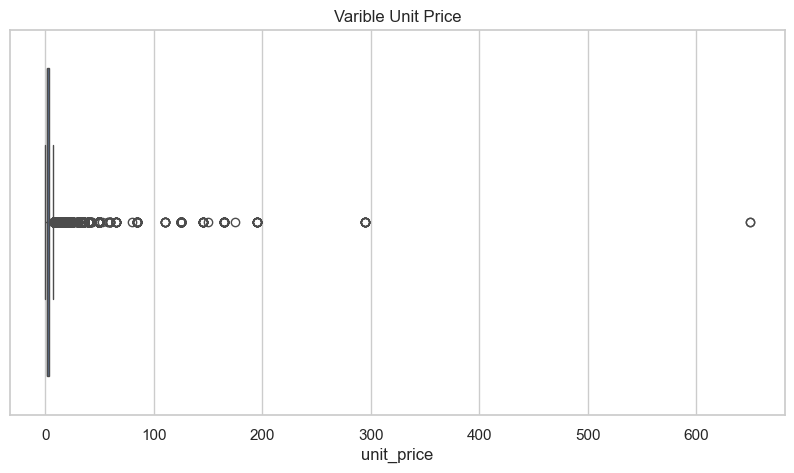

In [272]:
# Graficar un boxplot para identificar valores atípicos
plt.figure(figsize=(10,5))
sns.boxplot(x=df['unit_price'])
plt.title('Varible Unit Price')
plt.show()

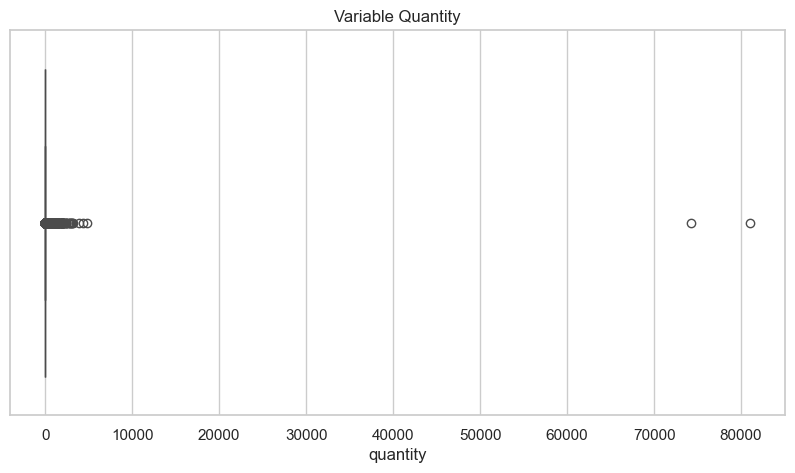

In [273]:
# Graficar un boxplot para identificar valores atípicos
plt.figure(figsize=(10,5))
sns.boxplot(x=df['quantity'])
plt.title('Variable Quantity')
plt.show()

In [274]:
#verificacion de los outliers, estos dos productos si son ventan por lo que no se eliminan 
df[df['quantity'] > 60000]

invoice_no stock_code                     description  quantity  \
36985      541431      23166  medium ceramic top storage jar     74215   
396017     581483      23843      paper craft  little birdie     80995   

              invoice_date  unit_price  customer_id          region     total  \
36985  2020-01-18 10:01:00        1.04        12346  United Kingdom   77183.6   
396017 2020-12-09 09:15:00        2.08        16446  United Kingdom  168469.6   

        time_diff month_year  numero_compras  ingresos_totales estado_cliente  \
36985         NaN    2020-01               1           77183.6        perdido   
396017      204.0    2020-12               3          168472.5       retenido   

            AVP       APF         CLTV  
36985   77183.6  0.000231  1057.309589  
396017  56157.5  0.000692  2307.842466

## Aplicacion del metodo RFM 

In [275]:

# Aplicacion del metodo RFM 

current_date = df['invoice_date'].max()

# Calcula Recencia, Frecuencia y Valor Monetario
rfm_df = df.groupby('customer_id').agg({
    'invoice_date': lambda x: (current_date - x.max()).days,
    'total': ['sum', 'count'],
})

rfm_df.columns = ['Recency', 'Monetary', 'Frequency']
rfm_df.reset_index(inplace=True)

# Asigna puntuaciones RFM
rfm_df['R_rank'] = pd.qcut(rfm_df['Recency'], 5, labels=False, duplicates='drop') + 1
rfm_df['F_rank'] = pd.qcut(rfm_df['Frequency'], 5, labels=False, duplicates='drop') + 1
rfm_df['M_rank'] = pd.qcut(rfm_df['Monetary'], 5, labels=False, duplicates='drop') + 1


rfm_df['RFM_Score'] = rfm_df['R_rank'] + rfm_df['F_rank'] + rfm_df['M_rank']

display(rfm_df.head())

customer_id  Recency  Monetary  Frequency  R_rank  F_rank  M_rank  \
0        12346      326  77183.60          1       5       1       5   
1        12347        1   4310.00        182       1       5       5   
2        12348       74   1437.24         27       4       2       4   
3        12349       18   1457.55         72       2       4       4   
4        12350      310    294.40         16       5       2       2   

   RFM_Score  
0         11  
1         11  
2         10  
3         10  
4          9

# NUEVO DF 

In [276]:
# Aplicar IQR para Recency, Frequency, y Monetary
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

rfm_df = remove_outliers(rfm_df, 'Recency')
rfm_df = remove_outliers(rfm_df, 'Frequency')
rfm_df = remove_outliers(rfm_df, 'Monetary')

In [277]:
rfm_df = rfm_df.merge(df[['customer_id', 'CLTV', 'estado_cliente']].drop_duplicates(), on='customer_id', how='left')

In [278]:
rfm_df

customer_id  Recency  Monetary  Frequency  R_rank  F_rank  M_rank  \
0           12348       74   1437.24         27       4       2       4   
1           12349       18   1457.55         72       2       4       4   
2           12350      310    294.40         16       5       2       2   
3           12352       35   1385.74         77       3       4       4   
4           12353      203     89.00          4       5       1       1   
...           ...      ...       ...        ...     ...     ...     ...   
3497        18278       73    173.90          9       4       1       1   
3498        18280      277    180.60         10       5       1       1   
3499        18281      180     80.82          7       5       1       1   
3500        18282        7    178.05         12       1       1       1   
3501        18287       42   1837.28         70       3       4       4   

      RFM_Score       CLTV estado_cliente  
0            10  19.688219       retenido  
1            10  19.966438       retenido  
2             9   4.032877       retenido  
3            11  18.982740       retenido  
4             7   1.219178       retenido  
...         ...        ...            ...  
3497          6   2.382192       retenido  
3498          7   2.473973       retenido  
3499          7   1.107123       retenido  
3500          3   2.439041       retenido  
3501         11  25.168219       retenido  

[3502 rows x 10 columns]

In [279]:
def asignar_segmento(Recency, Frequency, Monetary, cltv):
    if cltv > rfm_df['CLTV'].quantile(0.75):
        return 'Alto Valor'
    elif Frequency >= rfm_df['Frequency'].quantile(0.75):
        return 'Leal'
    elif Recency <= rfm_df['Recency'].quantile(0.25) and cltv >= rfm_df['CLTV'].quantile(0.50):
        return 'Potencial'
    elif Frequency >= rfm_df['Frequency'].quantile(0.50) and Recency <= rfm_df['Recency'].quantile(0.50):
        return 'Activo'
    elif cltv < rfm_df['CLTV'].quantile(0.25):
        return 'Cliente alto riesgo'
    else:
        return 'Valor Medio'


# Aplicar la función asignar_segmento a cada fila de rfm_df
rfm_df['CLTV_Segment'] = rfm_df.apply(lambda x: asignar_segmento(x['Recency'], x['Frequency'], x['Monetary'], x['CLTV']), axis=1)


In [280]:
def asignar_segmento(cltv):
    if cltv > rfm_df['CLTV'].quantile(0.8):  # Segmento más alto
        return 'Alto Valor'
    elif cltv > rfm_df['CLTV'].quantile(0.6):  # Segmento alto-medio
        return 'Leal'
    elif cltv > rfm_df['CLTV'].quantile(0.4):  # Segmento medio
        return 'Potencial'
    elif cltv > rfm_df['CLTV'].quantile(0.2):  # Segmento bajo-medio
        return 'Activo'
    else:  # Segmento más bajo
        return 'En riesgo/ Perdido'

# Aplicar la función al DataFrame
rfm_df['CLTV_Segment'] = rfm_df.apply(lambda x: asignar_segmento(x['CLTV']), axis=1)



In [281]:
rfm_df.sample(50)

customer_id  Recency  Monetary  Frequency  R_rank  F_rank  M_rank  \
3117        17640       86    621.66          5       4       1       3   
2966        17384       18    336.40         15       2       2       2   
235         12735      315    689.57         41       5       3       3   
3230        17837       41   1587.48        168       3       5       4   
231         12728       70    728.33         42       3       3       3   
879         13844       10    361.62         20       1       2       2   
2940        17345       14    537.74         87       2       4       3   
3451        18210        1   2621.38        134       1       5       5   
3414        18155       74    371.62         25       4       2       2   
350         12948       15   2064.95        116       2       4       5   
2292        16227      224    314.22          6       5       1       2   
1549        14995       38    233.23         61       3       4       1   
1808        15415      313    572.81         48       5       3       3   
2781        17063       20   1461.14         78       2       4       4   
781         13686      182     72.00          8       5       1       1   
794         13708      270    294.88         50       5       3       2   
1878        15541      113     85.13         29       4       2       1   
448         13133      273    109.80          7       5       1       1   
2440        16473      164    316.11         18       4       2       2   
1212        14419       10   1058.06        206       1       5       4   
824         13750       53   1647.26         24       3       2       4   
1770        15351       11   1960.11        225       1       5       4   
2192        16076        2   2234.73        129       1       5       5   
337         12928       34   2062.70         84       3       4       5   
2036        15796        0   2710.56        132       1       5       5   
85          12493      165    415.74         21       4       2       2   
2670        16882       66    705.12         39       3       3       3   
2413        16431      212    642.81         83       5       4       3   
868         13824       32   1698.94         46       2       3       4   
1531        14964      246    206.21         13       5       1       1   
4           12353      203     89.00          4       5       1       1   
1518        14946       13    100.90          3       2       1       1   
778         13681       17    827.83         57       2       3       3   
1639        15133      127    982.42         29       4       2       4   
3449        18205       35    517.36         32       3       3       3   
1020        14079      124    375.10         12       4       1       2   
1732        15281       58   2332.15        139       3       5       5   
1858        15511       11    909.23        160       1       5       3   
319         12891      185    331.00          3       5       1       2   
3101        17615      129    329.60         14       4       1       2   
2553        16671       27   1692.27          6       2       1       4   
164         12615        1   2093.19        101       1       4       5   
1271        14511       10   1314.81         68       1       4       4   
127         12564      260    402.90         20       5       2       2   
2714        16955      184    518.67         25       5       2       3   
57          12438       13   2466.85         96       2       4       5   
1572        15031        3    668.14        111       1       4       3   
1725        15270       15   2379.49         41       2       3       5   
666         13499       17   1159.11         42       2       3       4   
1953        15660       24   1600.86         90       2       4       4   

      RFM_Score       CLTV estado_cliente        CLTV_Segment  
3117          8   8.515890       retenido           Potencial  
2966          6   4.608219       retenido           

In [282]:
#Funcion para la segmentacion de los clientes segun su RFM score
def segment_customer(row):
   if row['RFM_Score'] > 12:
         return 'Alto valor'
   elif row['RFM_Score'] > 9:
    return 'Leal'
   elif row['RFM_Score'] > 6:
    return 'Potencial'
   elif row['RFM_Score'] > 3:
    return 'Activo'
   else:
     return 'Cliente Perdido' 

#Aplica la función de segmentación a cada fila del DataFrame
rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1)

In [283]:
# Conteo de clientes por segmento
print(rfm_df['Segment'].value_counts())

Segment
Potencial          1665
Leal               1114
Activo              590
Alto valor           98
Cliente Perdido      35
Name: count, dtype: int64


In [284]:
rfm_df.sample(20)

customer_id  Recency  Monetary  Frequency  R_rank  F_rank  M_rank  \
2706        16947      235    406.48         21       5       2       2   
338         12929      312    117.85          8       5       1       1   
722         13590       10   1981.92         87       1       4       4   
500         13221      239    844.86         65       5       4       3   
1242        14470       11    461.19         43       1       3       2   
3478        18246       23    596.10          4       2       1       3   
2203        16093      106     17.00          1       4       1       1   
2994        17430       32    265.76         14       2       1       2   
474         13171       21    468.41         46       2       3       2   
2433        16462       73    136.00          3       4       1       1   
1523        14953       24    289.82         55       2       3       2   
2007        15746      133    196.88         28       4       2       1   
1728        15275       37    615.14         41       3       3       3   
1330        14620      205    412.78         26       5       2       2   
1071        14173       10    450.84         29       1       2       2   
2123        15949       16    364.72         19       2       2       2   
1609        15092      214    457.81         26       5       2       2   
1346        14642       58     96.12          2       3       1       1   
424         13091       27    345.82         21       2       2       2   
1490        14890      253    125.65          7       5       1       1   

      RFM_Score       CLTV estado_cliente        CLTV_Segment    Segment  
2706          9   5.568219       retenido              Activo  Potencial  
338           7   1.614384       retenido  En riesgo/ Perdido  Potencial  
722           9  27.149589       retenido          Alto Valor  Potencial  
500          12  11.573425       retenido                Leal       Leal  
1242          6   6.317671       retenido           Potencial     Activo  
3478          6   8.165753       retenido           Potencial     Activo  
2203          6   0.232877        perdido  En riesgo/ Perdido     Activo  
2994          5   3.640548       retenido              Activo     Activo  
474           7   6.416575       retenido           Potencial  Potencial  
2433          6   1.863014       retenido  En riesgo/ Perdido     Activo  
1523          7   3.970137       retenido              Activo  Potencial  
2007          7   2.696986       retenido  En riesgo/ Perdido  Potencial  
1728          9   8.426575       retenido           Potencial  Potencial  
1330          9   5.654521       retenido           Potencial  Potencial  
1071          5   6.175890       retenido           Potencial     Activo  
2123          6   4.996164       retenido              Activo     Activo  
1609          9   6.271370       retenido           Potencial  Potencial  
1346          5   1.316712       retenido  En riesgo/ Perdido     Activo  
424           6   4.737260       retenido              Activo     Activo  
1490          7   1.721233       retenido  En riesgo/ Perdido  Potencial

In [285]:
rfm_df['CLTV_Segment'].value_counts()

CLTV_Segment
Alto Valor            701
En riesgo/ Perdido    701
Activo                700
Leal                  700
Potencial             700
Name: count, dtype: int64

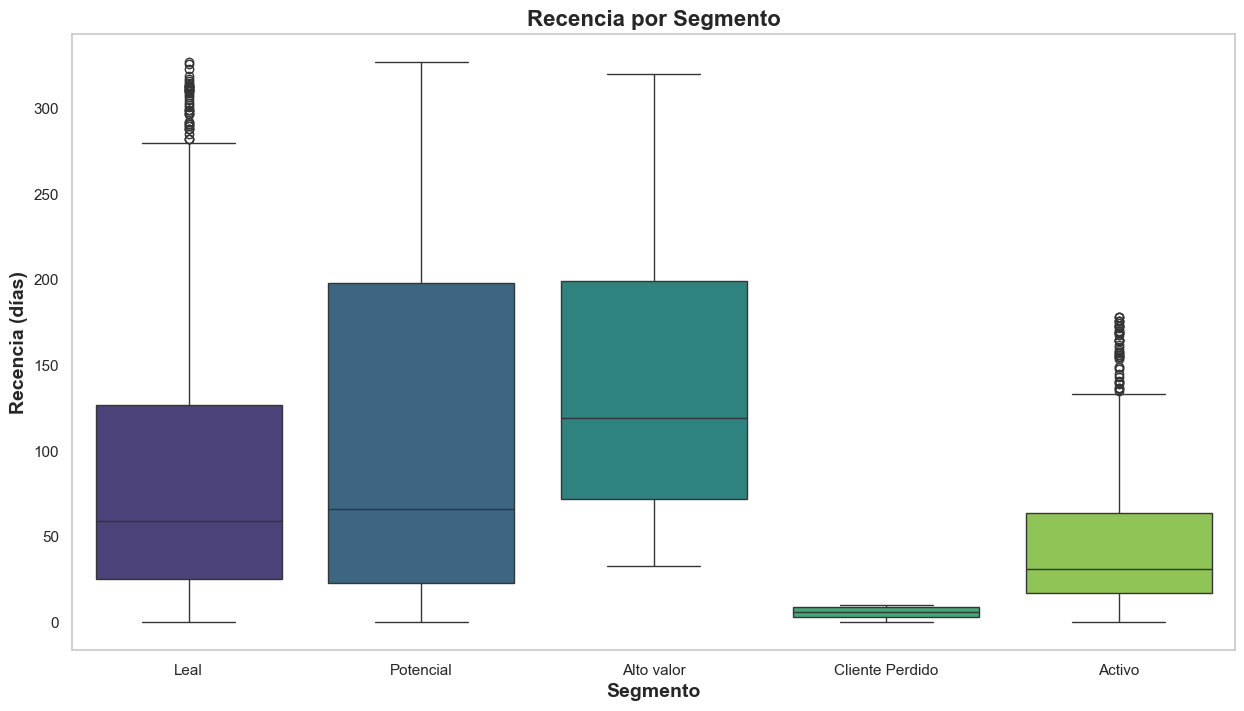

In [286]:
# Gráfico de Caja y Bigote para Recencia por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Recency', palette='viridis', hue='Segment')
plt.title('Recencia por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Recencia (días)', fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
plt.grid(False)
plt.savefig('recencia_por_segmento.jpeg', format='jpeg')
plt.show()

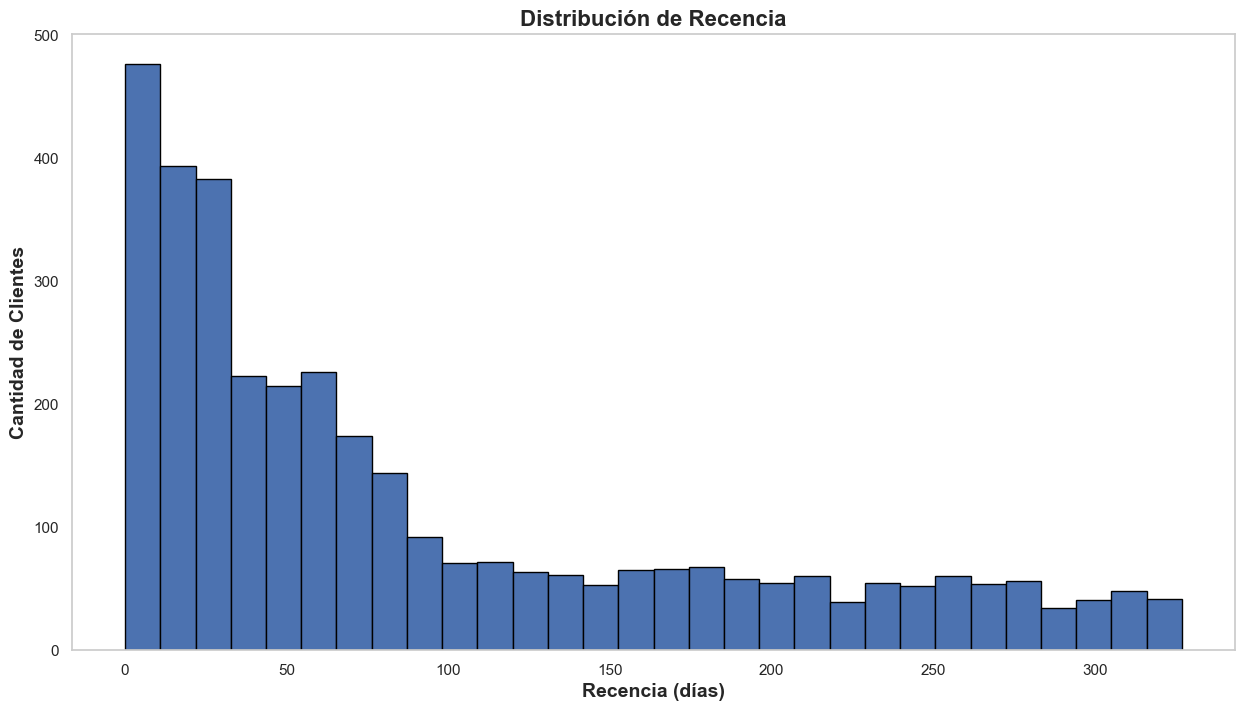

In [287]:
# Histograma
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
rfm_df['Recency'].hist(bins=30, edgecolor='black', grid=False)
plt.title('Distribución de Recencia', fontsize=16, fontweight='bold')
plt.xlabel('Recencia (días)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
plt.savefig('distrubicion_de_recencia.jpeg', format='jpeg')
plt.show()



Se realizo un analisis para visualizar cuandos dias suelen esperar los clientes hasta su sigiente compra. Como se observa la mayoria de los clientes suelen esperar ente 50 y 70 dias entre sus compras.

Lo que observamos en esta gráfica es la distribución de clientes por su antigüedad. La mayor concentración de clientes se encuentra en el rango de 0 a 6 meses, lo que sugiere que la empresa tiene una alta tasa de adquisición de nuevos clientes. A medida que aumenta la antigüedad, el número de clientes disminuye, lo que indica que la empresa tiene cierta rotación de clientes.

Se muestra una distribución típica de clientes por antigüedad, con una alta concentración de nuevos clientes y una disminución gradual a medida que aumenta la antigüedad. Esto sugiere que la empresa es efectiva en la adquisición de nuevos clientes, pero necesita mejorar sus estrategias de retención para mantener a los clientes a lo largo del tiempo.


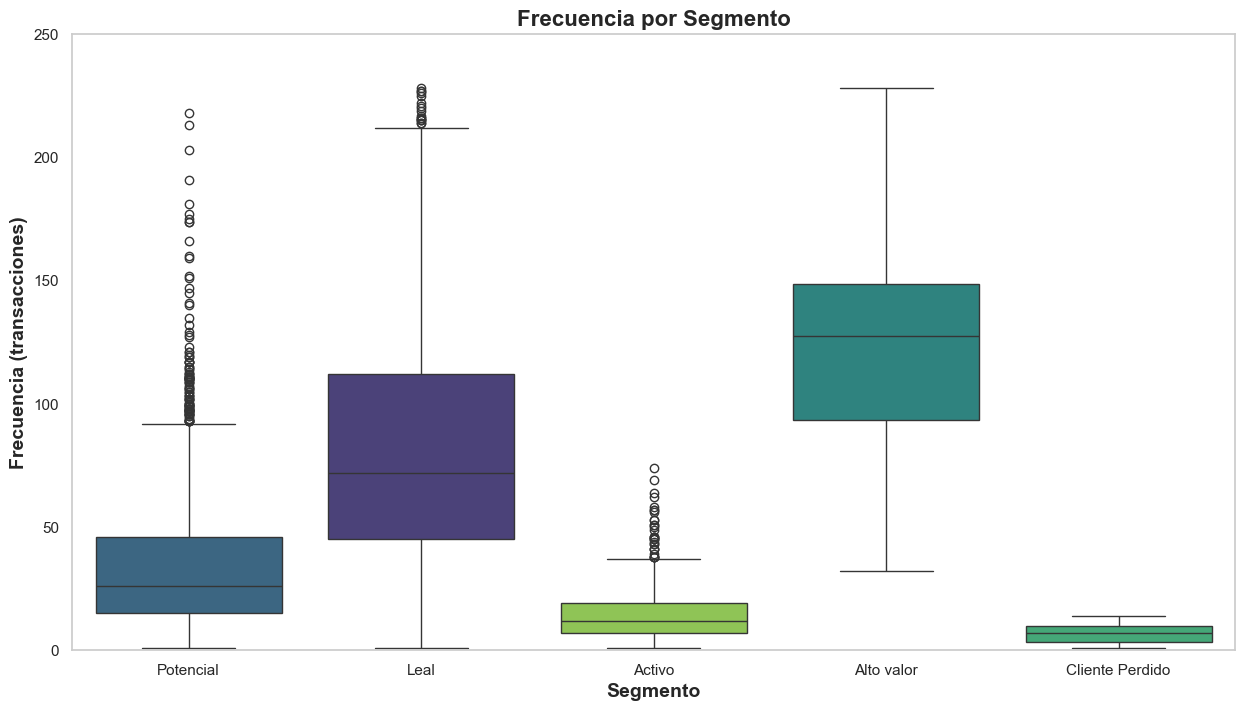

In [288]:
# Gráfico de Caja y Bigote para Frecuencia por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Frequency', palette='viridis', order=rfm_df['Segment'].value_counts().index, hue='Segment' )#showfliers=False
plt.title('Frecuencia por Segmento',  fontsize=16, fontweight='bold')
plt.xlabel('Segmento',  fontsize=14, fontweight='bold')
plt.ylabel('Frecuencia (transacciones)',  fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
#plt.ylim(0, 410) CON OUTLIERS
plt.ylim(0, 250)
plt.grid(False)
plt.savefig('frecuencia_por_segmento.jpeg', format='jpeg')
plt.show()



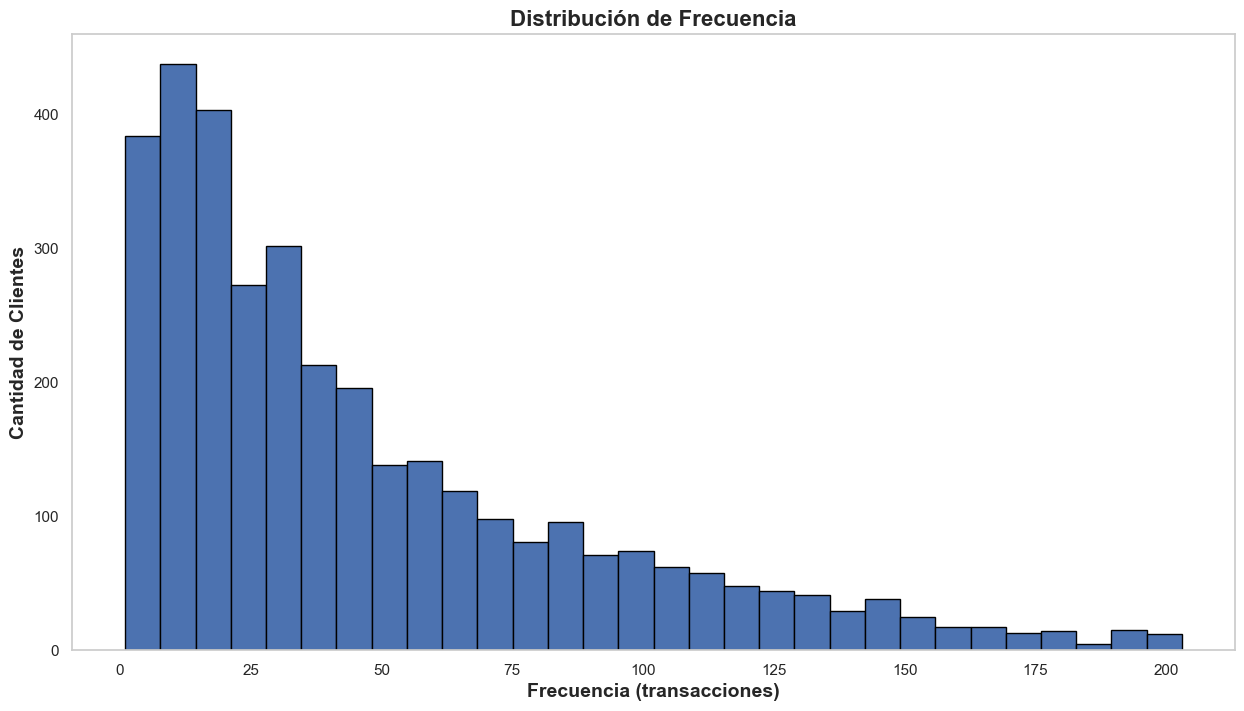

In [289]:
#histograma
sns.set(style="whitegrid")
filtered_data_f = rfm_df[rfm_df['Frequency'] < rfm_df['Frequency'].quantile(0.99)]
plt.figure(figsize=(15, 8))
filtered_data_f['Frequency'].hist(bins=30, edgecolor='black', grid=False)
plt.title('Distribución de Frecuencia', fontsize=16, fontweight='bold')
plt.xlabel('Frecuencia (transacciones)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
plt.savefig('distribucion_de_frecuencia.jpeg', format='jpeg')
plt.show()



Podemos observar que existe mas cantidad de cuentes que realizan entre 1 y 50 compras, mientras que resulta menos comun que los clientes realicen mas de 100 compras dentro de la tienda. La alta concentración de clientes en el rango de 1 a 50 compras sugiere que la empresa tiene una base de clientes amplia y diversa, con muchos clientes que realizan compras ocasionales o de baja frecuencia.

La presencia de clientes que realizan más de 100 compras indica que la empresa tiene un segmento de clientes leales y comprometidos que generan un alto volumen de ventas. Sin embargo, el número relativamente bajo de clientes en este segmento sugiere que existe un potencial para aumentar la fidelidad y el gasto entre los clientes existentes.

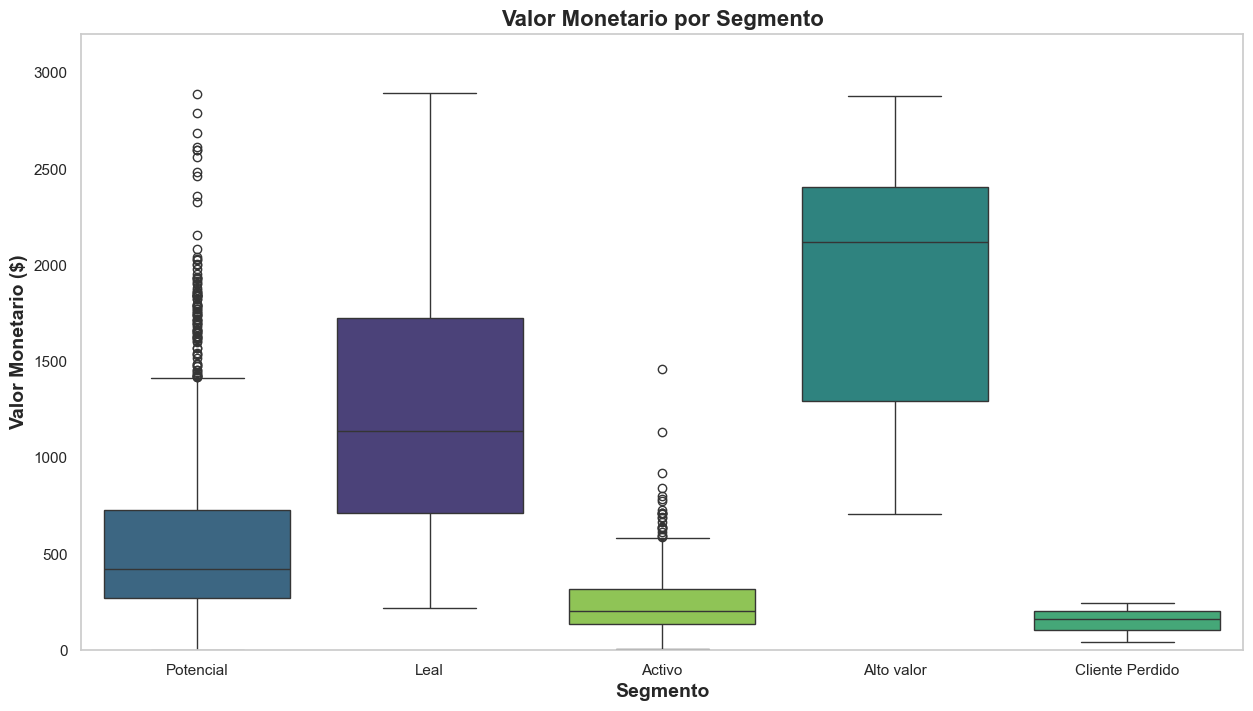

In [290]:
# Gráfico de Caja y Bigote para Valor Monetario por Segmento
plt.figure(figsize=(15, 8))
sns.boxplot(data=rfm_df, x='Segment', y='Monetary', palette='viridis', order=rfm_df['Segment'].value_counts().index, hue='Segment')
plt.title('Valor Monetario por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
#plt.xticks(rotation=45)
#plt.ylim(0, 7000) CON OUTLIERS
plt.ylim(0, 3200)
plt.grid(False)
plt.savefig('valor_monetario_por_segmento.jpeg', format='jpeg')
plt.show()


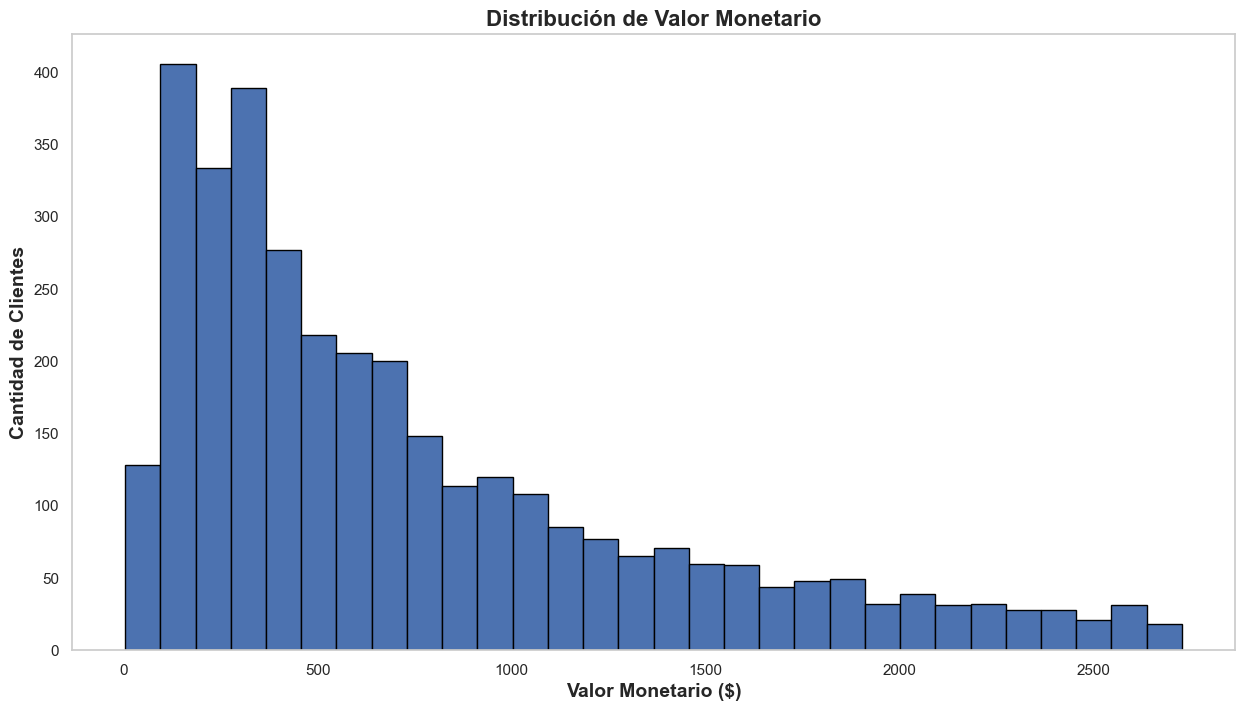

In [291]:
#histograma
sns.set(style="whitegrid")
filtered_data_m = rfm_df[rfm_df['Monetary'] < rfm_df['Monetary'].quantile(0.99)]
plt.figure(figsize=(15, 8))
filtered_data_m['Monetary'].hist(bins=30, edgecolor='black', grid= False)
plt.title('Distribución de Valor Monetario', fontsize=16, fontweight='bold')
plt.xlabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad de Clientes', fontsize=14, fontweight='bold')
plt.ticklabel_format(style='plain', axis='x')
plt.savefig('distribucion_valor_monetario.jpeg', format='jpeg')
plt.show()



Se observa que la mayoría de los clientes se encuentran en el rango de $0 a $200, mientras que es menos común que los clientes gasten más de $1000.
La alta concentración de clientes en el rango de $0 a $200 sugiere que la empresa tiene una base de clientes amplia y diversa, con muchos clientes que realizan compras de bajo valor.

La presencia de clientes que gastan más de $1000 indica que la empresa tiene segmentos de clientes con mayor poder adquisitivo que realizan compras de alto valor. Sin embargo, el número relativamente bajo de clientes en este segmento sugiere que existe un potencial para aumentar las ventas entre estos clientes.


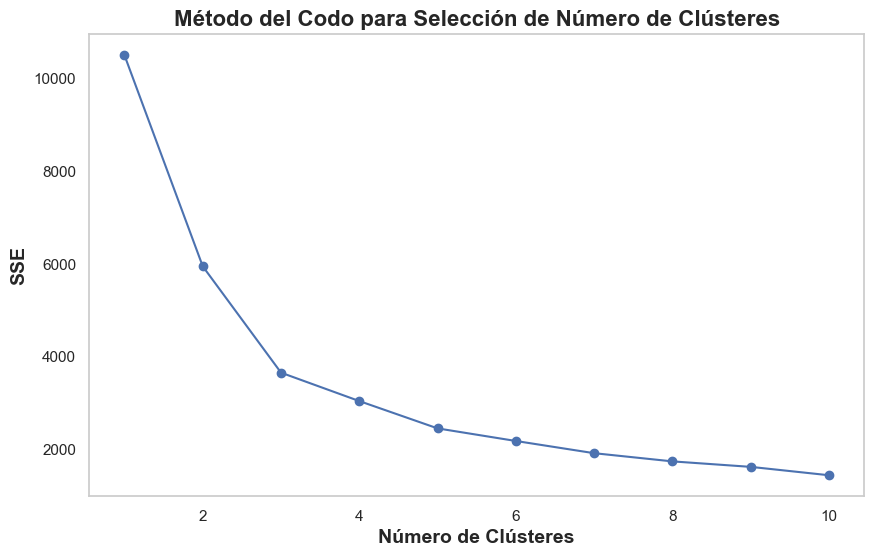

In [292]:
# Normalizar los datos
scaler = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Método del codo para encontrar el número óptimo de clústeres
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_normalized)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Método del Codo para Selección de Número de Clústeres', fontsize=16, fontweight='bold')
plt.xlabel('Número de Clústeres', fontsize=14, fontweight='bold')
plt.ylabel('SSE', fontsize=14, fontweight='bold')
plt.grid(False)
plt.show()
# Aplicar k-means con el número óptimo de clústeres (supongamos k=5)


In [293]:
# Aplicar k-means con el número óptimo de clústeres 
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_normalized)


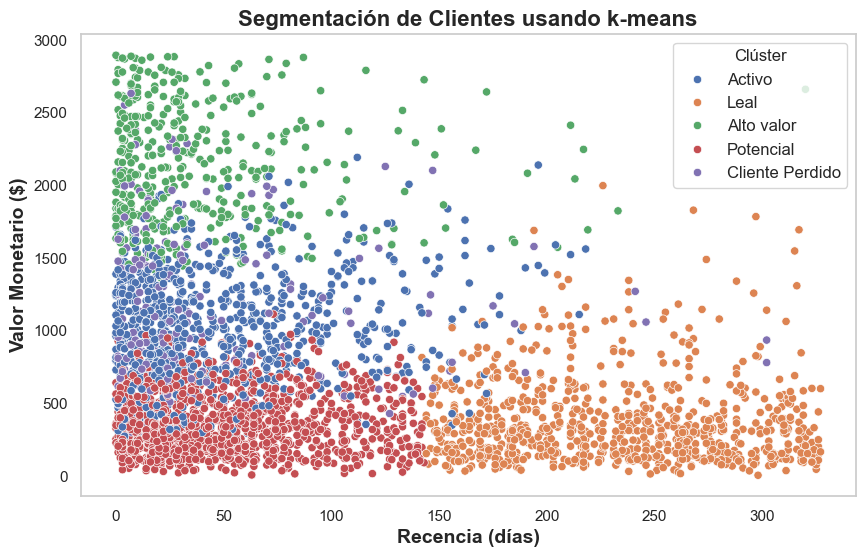

In [294]:
# Crear un diccionario de mapeo de etiquetas
cluster_names = {
    0: 'Potencial',
    1: 'Cliente Perdido',
    2: 'Leal',
    3: 'Alto valor',
    4: 'Activo'
}

# Asignar las etiquetas a cada cliente
rfm_df['Cluster_name'] = rfm_df['Cluster'].map(cluster_names)

# Visualizar los clústeres
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Monetary', hue='Cluster_name')
plt.title('Segmentación de Clientes usando k-means', fontsize=16, fontweight='bold')
plt.xlabel('Recencia (días)', fontsize=14, fontweight='bold')
plt.ylabel('Valor Monetario ($)', fontsize=14, fontweight='bold')
plt.legend(title='Clúster', fontsize=12)
plt.grid(False)
plt.ticklabel_format(style='plain', axis='y')
plt.savefig('segmentacion de clientes k-means.jpeg', format='jpeg')
plt.show()

In [295]:
# Distribución de clientes por clúster
rfm_df['Cluster'].value_counts()

Cluster
0    1230
2     828
4     825
3     411
1     208
Name: count, dtype: int64

In [296]:
print(rfm_df['Cluster_name'].value_counts())

Cluster_name
Potencial          1230
Leal                828
Activo              825
Alto valor          411
Cliente Perdido     208
Name: count, dtype: int64


In [297]:
# Distribución de clientes por clúster ordenado
print(rfm_df['Cluster_name'].value_counts())

# Estadísticas descriptivas por clúster ordenado
cluster_summary_ordered = rfm_df.groupby('Cluster_name').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(1)
display("Cluster Summary Ordered:", cluster_summary_ordered)

Cluster_name
Potencial          1230
Leal                828
Activo              825
Alto valor          411
Cliente Perdido     208
Name: count, dtype: int64


'Cluster Summary Ordered:'

Recency        Frequency        Monetary              
                   mean median      mean median     mean  median count
Cluster_name                                                          
Activo             48.9   35.0      59.5   58.0   1017.8   994.6   825
Alto valor         39.3   24.0     105.1  104.0   2137.0  2102.1   411
Cliente Perdido    42.8   24.0     163.9  157.5   1123.1   984.3   208
Leal              232.8  234.0      22.3   17.0    368.9   305.5   828
Potencial          52.6   46.0      22.2   20.0    355.4   328.3  1230

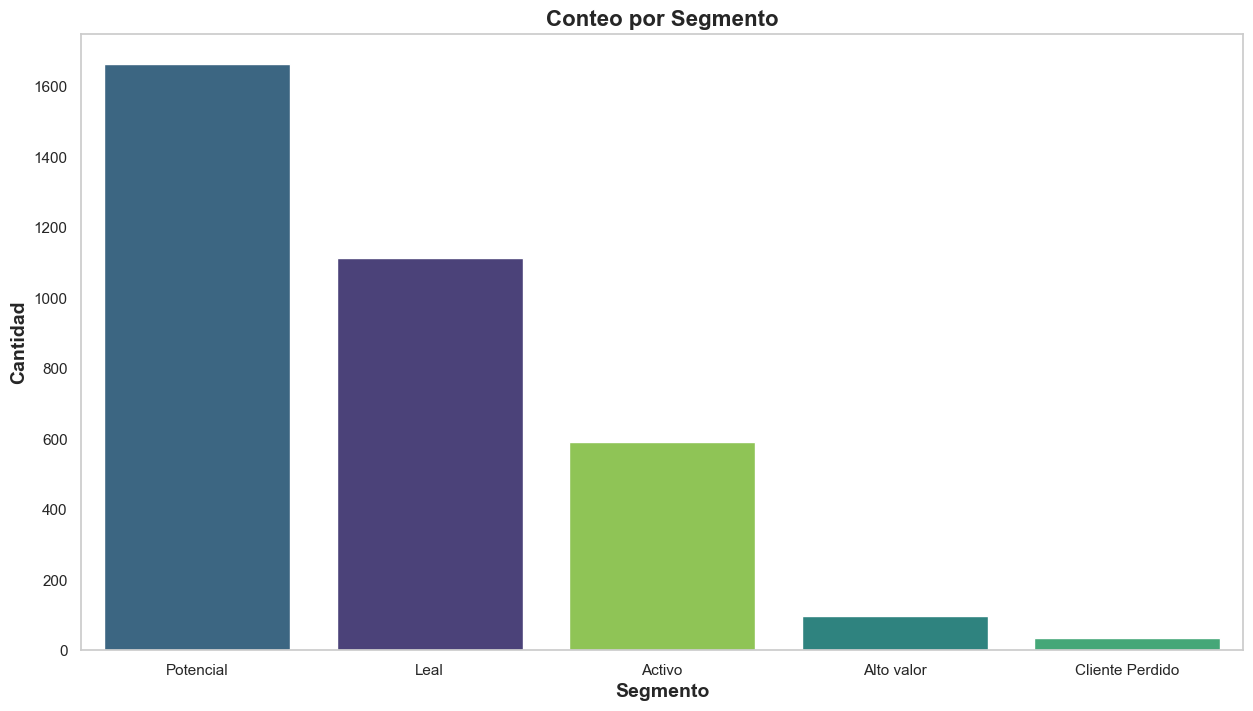

In [298]:
# Gráfico de Barras de la Distribución de Segmentos

sns.set(style="whitegrid")

plt.figure(figsize=(15,8))
sns.countplot(data=rfm_df, x='Segment', order=rfm_df['Segment'].value_counts().index, hue='Segment', palette='viridis', legend=False)


plt.title('Conteo por Segmento', fontsize=16, fontweight='bold')
plt.xlabel('Segmento', fontsize=14, fontweight='bold')
plt.ylabel('Cantidad', fontsize=14, fontweight='bold')

plt.grid(False)
plt.savefig('conteo_por_segmento.jpeg', format='jpeg')
plt.show()

Se realizo una segmentacion de cliente con base en la frecuencia con la que compran en la tienda, el monto que suelen gastar en sus compras y el tiempo transcurrido desde su ultima combra. Se obtuvieron 5 segmentos que dividen a los clientes en:
- *Potencial*: Son clientes con actividad superior a la media, en los cuales podemos enformar algun programa especifico para incentivarlos a convertirlos en clientes leales o de alto valor.
- *Leal*: En este grupo encontraremos a los clientes aliosos para la empresa, ya que son propensos a realizar compras repetidas y recomendar nuestros productos o servicios a otros.
- *Activo*: Clientes que utilizan compran nuestros productos de manera regular, sin llegar a superar el promedio de compras o visitas. Este segmento representa la mayor oportunidad de crecimiento para la empresa. Se deben implementar estrategias para aumentar la satisfacción y la lealtad de estos clientes.
- *Alto valor*: Estos clientes generan la mayor parte de los ingresos para la empresa. Es importante enfocarse en este segmento para mantener su satisfacción y lealtad.
- *Cliente Churn*: Estos clientes ya no compran nuestros productos. Es de vital importancia enfocarse en este segmento y analizar las razones por las que estos clientes se han perdido y tomar medidas para evitar que otros clientes se pierdan en el futuro.

In [299]:
#Creacion de la columna de cancelacion
def churn(row):
    if row == 'perdido':
        return 1 # cliente perdido o que probablemente abandone pronto
    else:
        return 0 #menos probabilidad de abandono 



rfm_df['Churn'] = rfm_df['estado_cliente'].apply(churn)

# Modelo de preduccion

In [300]:
# Invertir Recency para que los valores más altos sean mejor (menor recencia es mejor)
rfm_df['Recency'] = -rfm_df['Recency']

# Características adicionales
df_additional = df.groupby('customer_id').agg({
    'invoice_date': [lambda x: (current_date - x.min()).days,  # Customer Lifetime
                        lambda x: x.diff().mean().days],          # Average Time Between Purchases
    'stock_code': pd.Series.nunique,                                # Number of Distinct Products
   
})

df_additional.columns = ['Customer_Lifetime', 'Avg_Time_Between_Purchases', 'Distinct_Products']
df_additional.reset_index(inplace=True)

# Unir las características adicionales con las métricas RFM
rfm_df = pd.merge(rfm_df, df_additional, on='customer_id')
rfm_df.sample(20)

customer_id  Recency  Monetary  Frequency  R_rank  F_rank  M_rank  \
1158        14331     -123    462.66         28       4       2       2   
1793        15394       -9   2183.54         85       1       4       5   
2089        15883       -1    396.48         49       1       3       2   
2943        17349     -178    110.75          9       4       1       1   
1814        15424     -253    383.34         17       5       2       2   
16          12372      -71   1196.04         49       3       3       4   
2409        16425     -302    302.70         21       5       2       2   
1351        14649       -4   1417.29        199       1       5       4   
818         13740     -240    350.75         23       5       2       2   
2653        16849     -186    124.57          8       5       1       1   
1249        14480      -10    279.05         13       1       1       2   
1312        14584     -168   1042.26        100       4       4       4   
960         13974      -48    413.59         28       3       2       2   
3002        17442      -36   2248.56        135       3       5       5   
2609        16776      -59    388.28         76       3       4       2   
2939        17344      -45    160.57         32       3       3       1   
2201        16091     -154    315.06         18       4       2       2   
2849        17179     -177    711.79         80       4       4       3   
3335        18013     -154    187.29         31       4       3       1   
2643        16833        0   1106.53         47       1       3       4   

      RFM_Score       CLTV estado_cliente        CLTV_Segment     Segment  \
1158          8   6.337808       retenido           Potencial   Potencial   
1793         10  29.911507       retenido          Alto Valor        Leal   
2089          6   5.431233       retenido              Activo      Activo   
2943          6   1.517123       retenido  En riesgo/ Perdido      Activo   
1814          9   5.251233       retenido              Activo   Potencial   
16           10  16.384110       retenido                Leal        Leal   
2409          9   4.146575       retenido              Activo   Potencial   
1351         10  19.414932       retenido          Alto Valor        Leal   
818           9   4.804795       retenido              Activo   Potencial   
2653          7   1.706438       retenido  En riesgo/ Perdido   Potencial   
1249          4   3.822603       retenido              Activo      Activo   
1312         12  14.277534       retenido                Leal        Leal   
960           7   5.665616       retenido           Potencial   Potencial   
3002         13  30.802192       retenido          Alto Valor  Alto valor   
2609          9   5.318904       retenido              Activo   Potencial   
2939          7   2.199589       retenido  En riesgo/ Perdido   Potencial   
2201          8   4.315890       retenido              Activo   Potencial   
2849         11   9.750548       retenido                Leal        Leal   
3335          8   2.565616       retenido  En riesgo/ Perdido   Potencial   
2643          8  15.157945       retenido                Leal   Potencial   

      Cluster     Cluster_name  Churn  Customer_Lifetime  \
1158        0        Potencial      0                134   
1793        3       Alto valor      0                359   
2089        0        Potencial      0                 32   
2943        2             Leal      0                178   
1814        2             Leal      0                253   
16          4           Activo      0                297   
2409        2             Leal      0                302   
1351        1  Cliente Perdido      0                211   
818         2             Leal      0                240   
2653        2             Leal      0                186   
1249        0        Potencial      0                 10   
1312        4           Activo      0                197   
960         0        Potencial  

Churn
0    3444
1      58
Name: count, dtype: int64


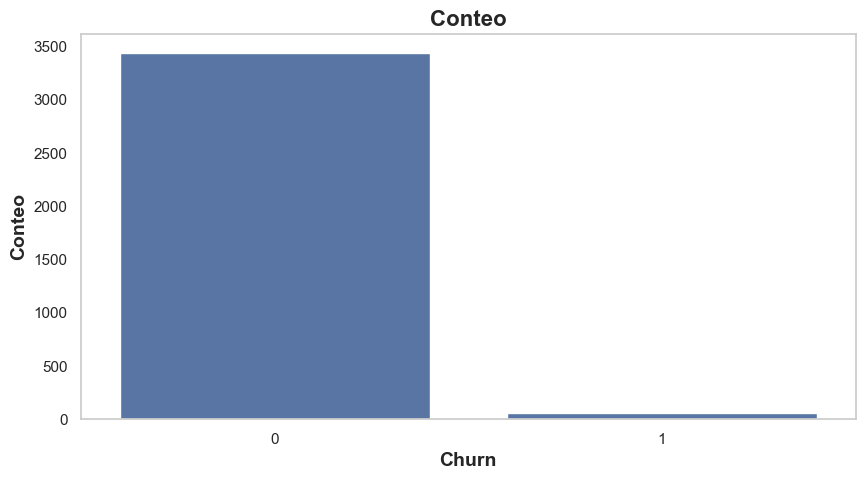

In [301]:
#Vamos a explorar como se comporta nuestra variable objetivo
class_counts = rfm_df['Churn'].value_counts()

print(class_counts)
plt.figure(figsize=(10,5))
plt.title('Conteo', fontsize=16, fontweight='bold')
plt.xlabel('Churn', fontsize=14, fontweight='bold')
plt.ylabel('Conteo', fontsize=14, fontweight='bold')
sns.countplot(x='Churn', data=rfm_df)
plt.grid(False)
plt.show()

Se observa que nuestros datos se encuentran totalmente desbalanceados, dato a tomar en cuenta para la prediccion.

In [302]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X = rfm_df[['Recency', 'Frequency', 'Monetary', 'Distinct_Products']]
y = rfm_df['Churn']

# Ajustar y transformar el conjunto de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=12345)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=12345)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [303]:
# Crear un pipeline para el manejo de los modelos

pipelines = {
        'xgb': Pipeline([
        ('scaler', StandardScaler()),  # Escalador estándar
        ('classifier', XGBClassifier(random_state=42))
    ]),
    'lgr': Pipeline([
        ('scaler', StandardScaler()),  # Escalador estándar
        ('classifier', LogisticRegression(penalty="elasticnet", l1_ratio=0.5))  
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()),  # Escalador estándar
        ('classifier', KNeighborsClassifier())
    ])
}

In [304]:
param_grids = {
    
    'xgb': {'classifier__n_estimators': [10, 30, 50],
           'classifier__subsample': [0.8, 0.9, 1],
           'classifier__gamma': [0, 0.1, 0.200],
           'classifier__learning_rate': [0.1, 0.01, 0.001],
           'classifier__colsample_bytree': [0.8, 0.9, 1],
           'classifier__max_depth': [3, 5, 10]},
           
    'lgr': {
        'classifier__penalty': ['elasticnet'],
        'classifier__solver': ['saga'],
        'classifier__class_weight': ['balanced']
    },
    'knn': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto'],
        'classifier__leaf_size': [10, 30, 50],
        'classifier__p': [1, 2]
    }
}


In [305]:
# Inicializar una lista para almacenar los resultados
results = []

stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=stratified_k_fold,
                               scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Evaluar el modelo en el conjunto de prueba
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
    y_pred = grid_search.predict(X_test)
    
        # Aplicar umbral a las probabilidades
    umbral = 0.5  # Umbral de 0.5 para clasificación binaria
    y_pred_binario = np.where(y_pred_proba >= umbral, 1, 0)

    # Calcular la precisión con las predicciones binarias
    acc_score = accuracy_score(y_test, y_pred_binario)
    f1 = f1_score(y_test, y_pred_binario)
    precision = precision_score(y_test, y_pred_binario)
    recall = recall_score(y_test, y_pred_binario)
    roc_auc = roc_auc_score(y_test, y_pred_binario)
    
    # Guardar los resultados en la lista
    results.append({
        'Modelo': model_name,
        'AUC-ROC': roc_auc,
        'Exactitud': acc_score,
        'f1': f1,
        'Precision': precision,
        'recall': recall,
        'Mejores Parámetros': grid_search.best_params_,
        'Mejor AUC-ROC': grid_search.best_score_
    })

# Crear el DataFrame de resultados
results_df = pd.DataFrame(results)

# Mostrar la tabla de resultados
print(results_df)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\karin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



  Modelo   AUC-ROC  Exactitud        f1  Precision    recall  \
0    xgb  1.000000   1.000000  1.000000   1.000000  1.000000   
1    lgr  0.971657   0.944286  0.380952   0.235294  1.000000   
2    knn  0.666667   0.988571  0.500000   1.000000  0.333333   

                                  Mejores Parámetros  Mejor AUC-ROC  
0  {'classifier__colsample_bytree': 0.8, 'classif...       1.000000  
1  {'classifier__class_weight': 'balanced', 'clas...       0.989340  
2  {'classifier__algorithm': 'auto', 'classifier_...       0.966889  


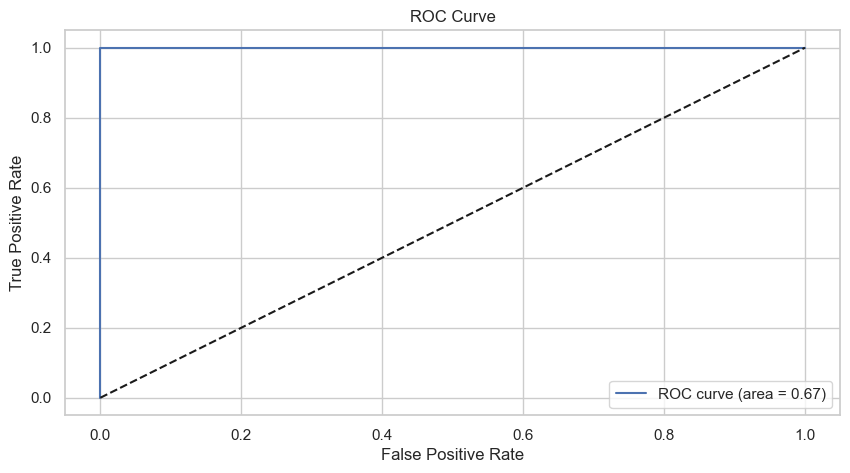

In [306]:
best_model = pipelines[results_df.sort_values('AUC-ROC', ascending=False).iloc[0]['Modelo']]
best_model.fit(X_train, y_train)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

Recomendaciones:

Con base en el analisis y la segmentacion de los datos realizados:

- **Implementar programas de fidelización para clientes**: Los programas de fidelización pueden ayudar a mantener a los clientes comprometidos y reducir la rotación. Estos programas pueden ofrecer beneficios como descuentos, puntos, acceso anticipado a nuevos productos o servicios, y eventos exclusivos.

- **Mejorar el servicio al cliente**: Un buen servicio al cliente puede ayudar a aumentar la satisfacción del cliente y reducir la probabilidad de que se vayan. La empresa debe asegurarse de que sus canales de servicio al cliente sean accesibles y fáciles de usar, y que sus empleados estén capacitados para brindar un servicio de alta calidad.

- **Analizar las razones por las que los clientes se van**: Es importante comprender por qué los clientes se van para poder abordar las causas subyacentes. La empresa puede realizar encuestas de salida o entrevistas a los clientes perdidos para obtener información sobre sus razones para irse.

- **Analizar los factores que impulsan la fidelización**: La empresa debería investigar los factores que impulsan la fidelización de los clientes que realizan más de 100 compras. Esto podría ayudar a identificar estrategias para aumentar la fidelidad entre otros segmentos de clientes.

- **Personalizar las comunicaciones de marketing**: La empresa podría personalizar sus comunicaciones de marketing en función del historial de compras de cada cliente. Esto podría ayudar a aumentar la relevancia de los mensajes de marketing y fomentar la conversión.

- **Analizar los factores que influyen en el gasto**: La empresa debería investigar los factores que influyen en el gasto de los clientes en diferentes rangos de precios. Esto podría incluir factores demográficos, psicográficos, comportamentales y relacionados con los productos y servicios de la empresa.

- **Implementar estrategias para aumentar el gasto promedio**: La empresa podría implementar estrategias para aumentar el gasto promedio de los clientes en el rango de $0 a $200. Esto podría incluir ofrecer descuentos por volumen, promociones especiales, programas de fidelización o mejorar la experiencia de compra en la tienda.

- **Atraer y fidelizar a los clientes de alto valor**: La empresa podría implementar estrategias de marketing personalizadas para atraer y fidelizar a los clientes que gastan más de $1000. Esto podría incluir ofrecer productos y servicios exclusivos, brindar un servicio al cliente excepcional o invitar a eventos especiales.